In [1]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
# y_test.shape, y_val.shape, y_train.shape
# X_train.shape, X_train.dtype, X_val.shape, X_val.dtype, X_test.shape, X_test.dtype

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [3]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # number of layers or depth
        self.losses = {'train':[], 'valid':[], 'valid_acc':[]}
        
        # The adaptive/learnable/updatable random feedforward
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.ys_prev = []
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        # Previous output layer
        self.ys_prev.append(0.0)

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        # Previous output layer
        ys_prev_L = []
        for _ in range(L):
            ys_prev_L.append(0.0)
        self.ys_prev.append(ys_prev_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Outout layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        # Previous output layer
        self.ys_prev.append(0.0)
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
#         dX = dout @ W.T # Backprop
        dX = dout @ W_fixed.T # fb alignment

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = l.tanh_forward(X=y)
        if train:
            caches.append((fc_cache, nl_cache))
        ys.append(y) # ys[0]
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, nl_caches, ys_L = [], [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = l.tanh_forward(X=y)
            ys_L.append(y) # ys[1][layer]
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
                nl_caches.append(nl_cache)
        if train:
            caches.append((fc_caches, nl_caches)) # caches[1]            
        ys.append(ys_L) # ys[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        if train:
            caches.append(fc_cache)
        ys.append(y) # ys[2]

        return ys, caches # for backpropating the error

    def loss_function(self, y, y_train):
        
        loss = cross_entropy(y, y_train) # softmax is included
        dy = dcross_entropy(y, y_train) # dsoftmax is included
        
        return loss, dy
        
    def train_backward(self, dy, caches, ys):
        grads, ys_prev = self.grads, self.ys_prev # initialized by Zero in every iteration/epoch
        
        # Output layer
        fc_cache = caches[2]
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
            dy *= ys[1][layer] - ys_prev[1][layer] # temporal diff instead of differentiable function
#             dy = l.tanh_backward(cache=nl_caches[layer], dout=dy) # diffable function
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
        dy *= ys[0] - ys_prev[0] # temporal diff instead of differentiable function
#         dy = l.tanh_backward(cache=nl_cache, dout=dy) # diffable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        ys_logit, _ = self.train_forward(X, train=False)
        y_logit = ys_logit[2] # last layer
        
        # if self.mode == 'classification':
        y_prob = l.softmax(y_logit) # for accuracy == acc
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_logit
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            ys, caches = self.train_forward(X_mini, train=True)
            loss, dy = self.loss_function(ys[2], y_mini)
            _, grads = self.train_backward(dy, caches, ys) # ys[0], ys[1] and ys_prev are used for backprop
            self.ys_prev = ys # for next iteration or epoch learning dW and db
            self.losses['train'].append(loss)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
                
            # Validate the updated model
            y_pred, y_logit = self.test(X_val)
            valid_loss, _ = self.loss_function(y_logit, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{} train loss: {:.4f} valid loss: {:.4f}, valid accuracy: {:.4f}'.format(
                    iter, loss, valid_loss, valid_acc))

        # Test the final model
        y_pred, y_logit = nn.test(X_test)
        loss, _ = self.loss_function(y_logit, y_test) # softmax is included in entropy loss function
        acc = np.mean(y_pred == y_test)
        print('Last iteration - Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.format(
            acc.mean(), acc.std(), loss))

In [4]:
# Hyper-parameters
n_iter = 1000000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 50 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 100 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-100 train loss: 2.2902 valid loss: 2.2901, valid accuracy: 0.1360
Iter-200 train loss: 2.2858 valid loss: 2.2894, valid accuracy: 0.1370
Iter-300 train loss: 2.2759 valid loss: 2.2886, valid accuracy: 0.1390
Iter-400 train loss: 2.3064 valid loss: 2.2879, valid accuracy: 0.1402
Iter-500 train loss: 2.2864 valid loss: 2.2871, valid accuracy: 0.1422
Iter-600 train loss: 2.2663 valid loss: 2.2864, valid accuracy: 0.1430
Iter-700 train loss: 2.2861 valid loss: 2.2856, valid accuracy: 0.1452
Iter-800 train loss: 2.2894 valid loss: 2.2849, valid accuracy: 0.1464
Iter-900 train loss: 2.2895 valid loss: 2.2842, valid accuracy: 0.1468
Iter-1000 train loss: 2.2675 valid loss: 2.2834, valid accuracy: 0.1488
Iter-1100 train loss: 2.3248 valid loss: 2.2826, valid accuracy: 0.1506
Iter-1200 train loss: 2.2905 valid loss: 2.2819, valid accuracy: 0.1512
Iter-1300 train loss: 2.2785 valid loss: 2.2811, valid accuracy: 0.1526
Iter-1400 train loss: 2.2842 valid loss: 2.2804, valid accuracy: 0.1534
I

Iter-11500 train loss: 2.2216 valid loss: 2.2096, valid accuracy: 0.3096
Iter-11600 train loss: 2.2263 valid loss: 2.2089, valid accuracy: 0.3108
Iter-11700 train loss: 2.2379 valid loss: 2.2083, valid accuracy: 0.3116
Iter-11800 train loss: 2.1800 valid loss: 2.2076, valid accuracy: 0.3136
Iter-11900 train loss: 2.2168 valid loss: 2.2070, valid accuracy: 0.3150
Iter-12000 train loss: 2.2151 valid loss: 2.2063, valid accuracy: 0.3164
Iter-12100 train loss: 2.1815 valid loss: 2.2056, valid accuracy: 0.3178
Iter-12200 train loss: 2.2177 valid loss: 2.2050, valid accuracy: 0.3208
Iter-12300 train loss: 2.1925 valid loss: 2.2043, valid accuracy: 0.3216
Iter-12400 train loss: 2.2278 valid loss: 2.2036, valid accuracy: 0.3226
Iter-12500 train loss: 2.2039 valid loss: 2.2030, valid accuracy: 0.3242
Iter-12600 train loss: 2.2221 valid loss: 2.2023, valid accuracy: 0.3250
Iter-12700 train loss: 2.2446 valid loss: 2.2017, valid accuracy: 0.3250
Iter-12800 train loss: 2.1821 valid loss: 2.2010, v

Iter-22800 train loss: 2.0936 valid loss: 2.1382, valid accuracy: 0.3970
Iter-22900 train loss: 2.1216 valid loss: 2.1376, valid accuracy: 0.3968
Iter-23000 train loss: 2.0918 valid loss: 2.1371, valid accuracy: 0.3972
Iter-23100 train loss: 2.1565 valid loss: 2.1365, valid accuracy: 0.3976
Iter-23200 train loss: 2.1508 valid loss: 2.1358, valid accuracy: 0.3974
Iter-23300 train loss: 2.1325 valid loss: 2.1352, valid accuracy: 0.3978
Iter-23400 train loss: 2.1525 valid loss: 2.1346, valid accuracy: 0.3974
Iter-23500 train loss: 2.1428 valid loss: 2.1340, valid accuracy: 0.3972
Iter-23600 train loss: 2.1173 valid loss: 2.1334, valid accuracy: 0.3978
Iter-23700 train loss: 2.1691 valid loss: 2.1328, valid accuracy: 0.3976
Iter-23800 train loss: 2.1253 valid loss: 2.1322, valid accuracy: 0.3984
Iter-23900 train loss: 2.1064 valid loss: 2.1316, valid accuracy: 0.3984
Iter-24000 train loss: 2.1544 valid loss: 2.1310, valid accuracy: 0.3986
Iter-24100 train loss: 2.0923 valid loss: 2.1304, v

Iter-34100 train loss: 2.0646 valid loss: 2.0728, valid accuracy: 0.4252
Iter-34200 train loss: 2.0723 valid loss: 2.0722, valid accuracy: 0.4256
Iter-34300 train loss: 2.1272 valid loss: 2.0717, valid accuracy: 0.4258
Iter-34400 train loss: 2.0824 valid loss: 2.0711, valid accuracy: 0.4262
Iter-34500 train loss: 2.1188 valid loss: 2.0705, valid accuracy: 0.4268
Iter-34600 train loss: 2.1308 valid loss: 2.0700, valid accuracy: 0.4264
Iter-34700 train loss: 2.0626 valid loss: 2.0694, valid accuracy: 0.4266
Iter-34800 train loss: 2.0804 valid loss: 2.0688, valid accuracy: 0.4268
Iter-34900 train loss: 2.0647 valid loss: 2.0683, valid accuracy: 0.4266
Iter-35000 train loss: 2.0479 valid loss: 2.0677, valid accuracy: 0.4278
Iter-35100 train loss: 2.1354 valid loss: 2.0672, valid accuracy: 0.4280
Iter-35200 train loss: 2.0695 valid loss: 2.0666, valid accuracy: 0.4280
Iter-35300 train loss: 2.0874 valid loss: 2.0660, valid accuracy: 0.4280
Iter-35400 train loss: 2.0230 valid loss: 2.0655, v

Iter-45400 train loss: 1.9669 valid loss: 2.0120, valid accuracy: 0.4442
Iter-45500 train loss: 2.0118 valid loss: 2.0115, valid accuracy: 0.4436
Iter-45600 train loss: 1.9712 valid loss: 2.0110, valid accuracy: 0.4446
Iter-45700 train loss: 1.9797 valid loss: 2.0105, valid accuracy: 0.4448
Iter-45800 train loss: 2.0504 valid loss: 2.0100, valid accuracy: 0.4448
Iter-45900 train loss: 2.0240 valid loss: 2.0094, valid accuracy: 0.4456
Iter-46000 train loss: 2.0404 valid loss: 2.0089, valid accuracy: 0.4456
Iter-46100 train loss: 2.0406 valid loss: 2.0084, valid accuracy: 0.4452
Iter-46200 train loss: 1.9731 valid loss: 2.0079, valid accuracy: 0.4450
Iter-46300 train loss: 2.0059 valid loss: 2.0073, valid accuracy: 0.4452
Iter-46400 train loss: 2.0284 valid loss: 2.0068, valid accuracy: 0.4458
Iter-46500 train loss: 1.9869 valid loss: 2.0063, valid accuracy: 0.4458
Iter-46600 train loss: 1.9729 valid loss: 2.0058, valid accuracy: 0.4460
Iter-46700 train loss: 2.0259 valid loss: 2.0052, v

Iter-56700 train loss: 1.9020 valid loss: 1.9550, valid accuracy: 0.4548
Iter-56800 train loss: 1.9661 valid loss: 1.9545, valid accuracy: 0.4548
Iter-56900 train loss: 2.0455 valid loss: 1.9540, valid accuracy: 0.4550
Iter-57000 train loss: 1.9486 valid loss: 1.9535, valid accuracy: 0.4548
Iter-57100 train loss: 1.9656 valid loss: 1.9530, valid accuracy: 0.4552
Iter-57200 train loss: 1.9897 valid loss: 1.9525, valid accuracy: 0.4556
Iter-57300 train loss: 1.9152 valid loss: 1.9521, valid accuracy: 0.4556
Iter-57400 train loss: 1.9867 valid loss: 1.9515, valid accuracy: 0.4554
Iter-57500 train loss: 2.0300 valid loss: 1.9511, valid accuracy: 0.4558
Iter-57600 train loss: 2.0671 valid loss: 1.9506, valid accuracy: 0.4568
Iter-57700 train loss: 1.9799 valid loss: 1.9501, valid accuracy: 0.4564
Iter-57800 train loss: 1.9958 valid loss: 1.9496, valid accuracy: 0.4560
Iter-57900 train loss: 2.0288 valid loss: 1.9491, valid accuracy: 0.4558
Iter-58000 train loss: 1.9320 valid loss: 1.9486, v

Iter-68000 train loss: 1.8782 valid loss: 1.9014, valid accuracy: 0.4690
Iter-68100 train loss: 1.9178 valid loss: 1.9009, valid accuracy: 0.4692
Iter-68200 train loss: 1.8982 valid loss: 1.9005, valid accuracy: 0.4694
Iter-68300 train loss: 1.8295 valid loss: 1.9000, valid accuracy: 0.4698
Iter-68400 train loss: 1.8918 valid loss: 1.8995, valid accuracy: 0.4692
Iter-68500 train loss: 1.9250 valid loss: 1.8991, valid accuracy: 0.4696
Iter-68600 train loss: 1.9217 valid loss: 1.8986, valid accuracy: 0.4696
Iter-68700 train loss: 1.9506 valid loss: 1.8982, valid accuracy: 0.4694
Iter-68800 train loss: 1.9332 valid loss: 1.8977, valid accuracy: 0.4694
Iter-68900 train loss: 1.8839 valid loss: 1.8973, valid accuracy: 0.4694
Iter-69000 train loss: 1.9370 valid loss: 1.8968, valid accuracy: 0.4698
Iter-69100 train loss: 1.9108 valid loss: 1.8964, valid accuracy: 0.4702
Iter-69200 train loss: 1.9524 valid loss: 1.8959, valid accuracy: 0.4698
Iter-69300 train loss: 1.8356 valid loss: 1.8954, v

Iter-79300 train loss: 1.8975 valid loss: 1.8507, valid accuracy: 0.4792
Iter-79400 train loss: 1.9040 valid loss: 1.8503, valid accuracy: 0.4788
Iter-79500 train loss: 1.8576 valid loss: 1.8498, valid accuracy: 0.4790
Iter-79600 train loss: 1.9043 valid loss: 1.8494, valid accuracy: 0.4792
Iter-79700 train loss: 1.8962 valid loss: 1.8489, valid accuracy: 0.4794
Iter-79800 train loss: 1.8288 valid loss: 1.8485, valid accuracy: 0.4790
Iter-79900 train loss: 1.8229 valid loss: 1.8481, valid accuracy: 0.4790
Iter-80000 train loss: 1.8440 valid loss: 1.8476, valid accuracy: 0.4794
Iter-80100 train loss: 1.8113 valid loss: 1.8472, valid accuracy: 0.4792
Iter-80200 train loss: 1.9027 valid loss: 1.8467, valid accuracy: 0.4790
Iter-80300 train loss: 1.8106 valid loss: 1.8463, valid accuracy: 0.4792
Iter-80400 train loss: 1.7838 valid loss: 1.8459, valid accuracy: 0.4796
Iter-80500 train loss: 1.8624 valid loss: 1.8454, valid accuracy: 0.4798
Iter-80600 train loss: 1.8413 valid loss: 1.8450, v

Iter-90600 train loss: 1.7884 valid loss: 1.8022, valid accuracy: 0.4906
Iter-90700 train loss: 1.8062 valid loss: 1.8017, valid accuracy: 0.4904
Iter-90800 train loss: 1.8619 valid loss: 1.8013, valid accuracy: 0.4902
Iter-90900 train loss: 1.8027 valid loss: 1.8009, valid accuracy: 0.4906
Iter-91000 train loss: 1.9343 valid loss: 1.8005, valid accuracy: 0.4910
Iter-91100 train loss: 1.8712 valid loss: 1.8001, valid accuracy: 0.4906
Iter-91200 train loss: 1.7606 valid loss: 1.7996, valid accuracy: 0.4910
Iter-91300 train loss: 1.7613 valid loss: 1.7992, valid accuracy: 0.4914
Iter-91400 train loss: 1.7813 valid loss: 1.7988, valid accuracy: 0.4910
Iter-91500 train loss: 1.6830 valid loss: 1.7984, valid accuracy: 0.4912
Iter-91600 train loss: 1.8728 valid loss: 1.7980, valid accuracy: 0.4912
Iter-91700 train loss: 1.7631 valid loss: 1.7976, valid accuracy: 0.4916
Iter-91800 train loss: 1.8469 valid loss: 1.7971, valid accuracy: 0.4914
Iter-91900 train loss: 1.8047 valid loss: 1.7968, v

Iter-101800 train loss: 1.7868 valid loss: 1.7564, valid accuracy: 0.4992
Iter-101900 train loss: 1.8039 valid loss: 1.7560, valid accuracy: 0.4990
Iter-102000 train loss: 1.7531 valid loss: 1.7556, valid accuracy: 0.4994
Iter-102100 train loss: 1.7931 valid loss: 1.7552, valid accuracy: 0.4990
Iter-102200 train loss: 1.7396 valid loss: 1.7548, valid accuracy: 0.4996
Iter-102300 train loss: 1.7283 valid loss: 1.7544, valid accuracy: 0.4994
Iter-102400 train loss: 1.7082 valid loss: 1.7540, valid accuracy: 0.4996
Iter-102500 train loss: 1.7312 valid loss: 1.7536, valid accuracy: 0.4996
Iter-102600 train loss: 1.6644 valid loss: 1.7532, valid accuracy: 0.4996
Iter-102700 train loss: 1.6148 valid loss: 1.7528, valid accuracy: 0.4998
Iter-102800 train loss: 1.6787 valid loss: 1.7524, valid accuracy: 0.5002
Iter-102900 train loss: 1.8638 valid loss: 1.7520, valid accuracy: 0.4996
Iter-103000 train loss: 1.8969 valid loss: 1.7516, valid accuracy: 0.5000
Iter-103100 train loss: 1.7740 valid l

Iter-112900 train loss: 1.7201 valid loss: 1.7130, valid accuracy: 0.5082
Iter-113000 train loss: 1.7567 valid loss: 1.7126, valid accuracy: 0.5084
Iter-113100 train loss: 1.6909 valid loss: 1.7122, valid accuracy: 0.5086
Iter-113200 train loss: 1.7178 valid loss: 1.7118, valid accuracy: 0.5084
Iter-113300 train loss: 1.6759 valid loss: 1.7115, valid accuracy: 0.5082
Iter-113400 train loss: 1.6493 valid loss: 1.7111, valid accuracy: 0.5086
Iter-113500 train loss: 1.7304 valid loss: 1.7107, valid accuracy: 0.5086
Iter-113600 train loss: 1.6158 valid loss: 1.7103, valid accuracy: 0.5086
Iter-113700 train loss: 1.8920 valid loss: 1.7100, valid accuracy: 0.5084
Iter-113800 train loss: 1.6470 valid loss: 1.7096, valid accuracy: 0.5086
Iter-113900 train loss: 1.7644 valid loss: 1.7092, valid accuracy: 0.5086
Iter-114000 train loss: 1.8218 valid loss: 1.7088, valid accuracy: 0.5086
Iter-114100 train loss: 1.7750 valid loss: 1.7084, valid accuracy: 0.5086
Iter-114200 train loss: 1.7926 valid l

Iter-124000 train loss: 1.7320 valid loss: 1.6714, valid accuracy: 0.5178
Iter-124100 train loss: 1.6443 valid loss: 1.6711, valid accuracy: 0.5180
Iter-124200 train loss: 1.7188 valid loss: 1.6707, valid accuracy: 0.5182
Iter-124300 train loss: 1.6430 valid loss: 1.6704, valid accuracy: 0.5182
Iter-124400 train loss: 1.6445 valid loss: 1.6700, valid accuracy: 0.5184
Iter-124500 train loss: 1.7354 valid loss: 1.6696, valid accuracy: 0.5182
Iter-124600 train loss: 1.6372 valid loss: 1.6692, valid accuracy: 0.5184
Iter-124700 train loss: 1.6832 valid loss: 1.6689, valid accuracy: 0.5182
Iter-124800 train loss: 1.6869 valid loss: 1.6685, valid accuracy: 0.5180
Iter-124900 train loss: 1.5320 valid loss: 1.6681, valid accuracy: 0.5184
Iter-125000 train loss: 1.7502 valid loss: 1.6678, valid accuracy: 0.5190
Iter-125100 train loss: 1.7423 valid loss: 1.6674, valid accuracy: 0.5188
Iter-125200 train loss: 1.7391 valid loss: 1.6670, valid accuracy: 0.5186
Iter-125300 train loss: 1.6625 valid l

Iter-135100 train loss: 1.7938 valid loss: 1.6314, valid accuracy: 0.5276
Iter-135200 train loss: 1.6328 valid loss: 1.6311, valid accuracy: 0.5278
Iter-135300 train loss: 1.6284 valid loss: 1.6307, valid accuracy: 0.5278
Iter-135400 train loss: 1.5241 valid loss: 1.6304, valid accuracy: 0.5276
Iter-135500 train loss: 1.7397 valid loss: 1.6301, valid accuracy: 0.5276
Iter-135600 train loss: 1.5686 valid loss: 1.6297, valid accuracy: 0.5280
Iter-135700 train loss: 1.6547 valid loss: 1.6294, valid accuracy: 0.5282
Iter-135800 train loss: 1.7534 valid loss: 1.6290, valid accuracy: 0.5282
Iter-135900 train loss: 1.6017 valid loss: 1.6287, valid accuracy: 0.5280
Iter-136000 train loss: 1.5571 valid loss: 1.6283, valid accuracy: 0.5282
Iter-136100 train loss: 1.5887 valid loss: 1.6280, valid accuracy: 0.5282
Iter-136200 train loss: 1.4503 valid loss: 1.6276, valid accuracy: 0.5284
Iter-136300 train loss: 1.8151 valid loss: 1.6273, valid accuracy: 0.5288
Iter-136400 train loss: 1.4789 valid l

Iter-146200 train loss: 1.5080 valid loss: 1.5930, valid accuracy: 0.5374
Iter-146300 train loss: 1.6450 valid loss: 1.5926, valid accuracy: 0.5376
Iter-146400 train loss: 1.6494 valid loss: 1.5923, valid accuracy: 0.5378
Iter-146500 train loss: 1.6015 valid loss: 1.5919, valid accuracy: 0.5382
Iter-146600 train loss: 1.5780 valid loss: 1.5916, valid accuracy: 0.5374
Iter-146700 train loss: 1.6152 valid loss: 1.5913, valid accuracy: 0.5378
Iter-146800 train loss: 1.6021 valid loss: 1.5909, valid accuracy: 0.5378
Iter-146900 train loss: 1.5477 valid loss: 1.5906, valid accuracy: 0.5382
Iter-147000 train loss: 1.6103 valid loss: 1.5903, valid accuracy: 0.5380
Iter-147100 train loss: 1.5319 valid loss: 1.5900, valid accuracy: 0.5378
Iter-147200 train loss: 1.5682 valid loss: 1.5896, valid accuracy: 0.5384
Iter-147300 train loss: 1.7099 valid loss: 1.5893, valid accuracy: 0.5382
Iter-147400 train loss: 1.5261 valid loss: 1.5890, valid accuracy: 0.5384
Iter-147500 train loss: 1.7117 valid l

Iter-157300 train loss: 1.5443 valid loss: 1.5559, valid accuracy: 0.5444
Iter-157400 train loss: 1.4880 valid loss: 1.5556, valid accuracy: 0.5446
Iter-157500 train loss: 1.6480 valid loss: 1.5553, valid accuracy: 0.5444
Iter-157600 train loss: 1.4322 valid loss: 1.5550, valid accuracy: 0.5446
Iter-157700 train loss: 1.5260 valid loss: 1.5547, valid accuracy: 0.5450
Iter-157800 train loss: 1.7370 valid loss: 1.5543, valid accuracy: 0.5452
Iter-157900 train loss: 1.5329 valid loss: 1.5540, valid accuracy: 0.5452
Iter-158000 train loss: 1.4867 valid loss: 1.5537, valid accuracy: 0.5456
Iter-158100 train loss: 1.5221 valid loss: 1.5533, valid accuracy: 0.5454
Iter-158200 train loss: 1.5325 valid loss: 1.5530, valid accuracy: 0.5454
Iter-158300 train loss: 1.6778 valid loss: 1.5526, valid accuracy: 0.5460
Iter-158400 train loss: 1.5909 valid loss: 1.5523, valid accuracy: 0.5462
Iter-158500 train loss: 1.6237 valid loss: 1.5520, valid accuracy: 0.5466
Iter-158600 train loss: 1.5930 valid l

Iter-168400 train loss: 1.5604 valid loss: 1.5201, valid accuracy: 0.5542
Iter-168500 train loss: 1.5086 valid loss: 1.5198, valid accuracy: 0.5544
Iter-168600 train loss: 1.5084 valid loss: 1.5194, valid accuracy: 0.5546
Iter-168700 train loss: 1.5059 valid loss: 1.5191, valid accuracy: 0.5542
Iter-168800 train loss: 1.6824 valid loss: 1.5188, valid accuracy: 0.5544
Iter-168900 train loss: 1.5197 valid loss: 1.5185, valid accuracy: 0.5548
Iter-169000 train loss: 1.4420 valid loss: 1.5182, valid accuracy: 0.5540
Iter-169100 train loss: 1.4715 valid loss: 1.5178, valid accuracy: 0.5544
Iter-169200 train loss: 1.5137 valid loss: 1.5175, valid accuracy: 0.5548
Iter-169300 train loss: 1.7079 valid loss: 1.5172, valid accuracy: 0.5546
Iter-169400 train loss: 1.5482 valid loss: 1.5169, valid accuracy: 0.5544
Iter-169500 train loss: 1.6103 valid loss: 1.5166, valid accuracy: 0.5548
Iter-169600 train loss: 1.3949 valid loss: 1.5163, valid accuracy: 0.5550
Iter-169700 train loss: 1.4648 valid l

Iter-179500 train loss: 1.4976 valid loss: 1.4853, valid accuracy: 0.5640
Iter-179600 train loss: 1.3954 valid loss: 1.4850, valid accuracy: 0.5636
Iter-179700 train loss: 1.5132 valid loss: 1.4847, valid accuracy: 0.5636
Iter-179800 train loss: 1.4913 valid loss: 1.4844, valid accuracy: 0.5640
Iter-179900 train loss: 1.4286 valid loss: 1.4841, valid accuracy: 0.5640
Iter-180000 train loss: 1.5432 valid loss: 1.4838, valid accuracy: 0.5642
Iter-180100 train loss: 1.5524 valid loss: 1.4835, valid accuracy: 0.5646
Iter-180200 train loss: 1.4959 valid loss: 1.4832, valid accuracy: 0.5644
Iter-180300 train loss: 1.5004 valid loss: 1.4829, valid accuracy: 0.5644
Iter-180400 train loss: 1.5562 valid loss: 1.4826, valid accuracy: 0.5640
Iter-180500 train loss: 1.4177 valid loss: 1.4823, valid accuracy: 0.5642
Iter-180600 train loss: 1.5686 valid loss: 1.4820, valid accuracy: 0.5644
Iter-180700 train loss: 1.4810 valid loss: 1.4816, valid accuracy: 0.5646
Iter-180800 train loss: 1.3930 valid l

Iter-190600 train loss: 1.3927 valid loss: 1.4520, valid accuracy: 0.5716
Iter-190700 train loss: 1.5235 valid loss: 1.4517, valid accuracy: 0.5712
Iter-190800 train loss: 1.5107 valid loss: 1.4513, valid accuracy: 0.5710
Iter-190900 train loss: 1.4251 valid loss: 1.4511, valid accuracy: 0.5712
Iter-191000 train loss: 1.3977 valid loss: 1.4508, valid accuracy: 0.5718
Iter-191100 train loss: 1.4126 valid loss: 1.4505, valid accuracy: 0.5720
Iter-191200 train loss: 1.4723 valid loss: 1.4502, valid accuracy: 0.5722
Iter-191300 train loss: 1.5038 valid loss: 1.4499, valid accuracy: 0.5726
Iter-191400 train loss: 1.3591 valid loss: 1.4495, valid accuracy: 0.5724
Iter-191500 train loss: 1.4182 valid loss: 1.4493, valid accuracy: 0.5722
Iter-191600 train loss: 1.5027 valid loss: 1.4490, valid accuracy: 0.5724
Iter-191700 train loss: 1.3912 valid loss: 1.4487, valid accuracy: 0.5726
Iter-191800 train loss: 1.3121 valid loss: 1.4484, valid accuracy: 0.5724
Iter-191900 train loss: 1.3351 valid l

Iter-201700 train loss: 1.5046 valid loss: 1.4197, valid accuracy: 0.5784
Iter-201800 train loss: 1.5337 valid loss: 1.4194, valid accuracy: 0.5780
Iter-201900 train loss: 1.2951 valid loss: 1.4191, valid accuracy: 0.5784
Iter-202000 train loss: 1.3952 valid loss: 1.4188, valid accuracy: 0.5784
Iter-202100 train loss: 1.5349 valid loss: 1.4185, valid accuracy: 0.5784
Iter-202200 train loss: 1.3579 valid loss: 1.4182, valid accuracy: 0.5784
Iter-202300 train loss: 1.4941 valid loss: 1.4179, valid accuracy: 0.5784
Iter-202400 train loss: 1.4787 valid loss: 1.4177, valid accuracy: 0.5784
Iter-202500 train loss: 1.4685 valid loss: 1.4174, valid accuracy: 0.5778
Iter-202600 train loss: 1.3403 valid loss: 1.4171, valid accuracy: 0.5780
Iter-202700 train loss: 1.4775 valid loss: 1.4168, valid accuracy: 0.5780
Iter-202800 train loss: 1.4268 valid loss: 1.4165, valid accuracy: 0.5780
Iter-202900 train loss: 1.3505 valid loss: 1.4162, valid accuracy: 0.5786
Iter-203000 train loss: 1.2901 valid l

Iter-212800 train loss: 1.3267 valid loss: 1.3888, valid accuracy: 0.5848
Iter-212900 train loss: 1.3401 valid loss: 1.3885, valid accuracy: 0.5850
Iter-213000 train loss: 1.3899 valid loss: 1.3882, valid accuracy: 0.5848
Iter-213100 train loss: 1.4283 valid loss: 1.3880, valid accuracy: 0.5842
Iter-213200 train loss: 1.5286 valid loss: 1.3877, valid accuracy: 0.5848
Iter-213300 train loss: 1.2957 valid loss: 1.3874, valid accuracy: 0.5850
Iter-213400 train loss: 1.4409 valid loss: 1.3871, valid accuracy: 0.5850
Iter-213500 train loss: 1.2929 valid loss: 1.3868, valid accuracy: 0.5852
Iter-213600 train loss: 1.2992 valid loss: 1.3866, valid accuracy: 0.5848
Iter-213700 train loss: 1.5958 valid loss: 1.3863, valid accuracy: 0.5848
Iter-213800 train loss: 1.4210 valid loss: 1.3860, valid accuracy: 0.5848
Iter-213900 train loss: 1.4920 valid loss: 1.3858, valid accuracy: 0.5852
Iter-214000 train loss: 1.5198 valid loss: 1.3855, valid accuracy: 0.5850
Iter-214100 train loss: 1.2741 valid l

Iter-223900 train loss: 1.4328 valid loss: 1.3591, valid accuracy: 0.5878
Iter-224000 train loss: 1.3298 valid loss: 1.3588, valid accuracy: 0.5880
Iter-224100 train loss: 1.3683 valid loss: 1.3585, valid accuracy: 0.5880
Iter-224200 train loss: 1.3303 valid loss: 1.3583, valid accuracy: 0.5882
Iter-224300 train loss: 1.5759 valid loss: 1.3580, valid accuracy: 0.5882
Iter-224400 train loss: 1.0602 valid loss: 1.3577, valid accuracy: 0.5884
Iter-224500 train loss: 1.4885 valid loss: 1.3575, valid accuracy: 0.5886
Iter-224600 train loss: 1.3249 valid loss: 1.3572, valid accuracy: 0.5886
Iter-224700 train loss: 1.3235 valid loss: 1.3570, valid accuracy: 0.5888
Iter-224800 train loss: 1.4723 valid loss: 1.3567, valid accuracy: 0.5886
Iter-224900 train loss: 1.3509 valid loss: 1.3564, valid accuracy: 0.5888
Iter-225000 train loss: 1.1645 valid loss: 1.3561, valid accuracy: 0.5888
Iter-225100 train loss: 1.5002 valid loss: 1.3559, valid accuracy: 0.5892
Iter-225200 train loss: 1.3825 valid l

Iter-235000 train loss: 1.3485 valid loss: 1.3305, valid accuracy: 0.5928
Iter-235100 train loss: 1.3962 valid loss: 1.3302, valid accuracy: 0.5930
Iter-235200 train loss: 1.1634 valid loss: 1.3299, valid accuracy: 0.5930
Iter-235300 train loss: 1.3458 valid loss: 1.3297, valid accuracy: 0.5932
Iter-235400 train loss: 1.2158 valid loss: 1.3294, valid accuracy: 0.5934
Iter-235500 train loss: 1.1754 valid loss: 1.3292, valid accuracy: 0.5934
Iter-235600 train loss: 1.4830 valid loss: 1.3289, valid accuracy: 0.5936
Iter-235700 train loss: 1.3757 valid loss: 1.3287, valid accuracy: 0.5936
Iter-235800 train loss: 1.3437 valid loss: 1.3284, valid accuracy: 0.5936
Iter-235900 train loss: 1.4635 valid loss: 1.3282, valid accuracy: 0.5934
Iter-236000 train loss: 1.3488 valid loss: 1.3280, valid accuracy: 0.5934
Iter-236100 train loss: 1.3283 valid loss: 1.3277, valid accuracy: 0.5936
Iter-236200 train loss: 1.4071 valid loss: 1.3274, valid accuracy: 0.5936
Iter-236300 train loss: 1.4606 valid l

Iter-246100 train loss: 1.3032 valid loss: 1.3031, valid accuracy: 0.5994
Iter-246200 train loss: 1.3467 valid loss: 1.3029, valid accuracy: 0.5998
Iter-246300 train loss: 1.3189 valid loss: 1.3027, valid accuracy: 0.5998
Iter-246400 train loss: 1.2594 valid loss: 1.3024, valid accuracy: 0.5998
Iter-246500 train loss: 1.3034 valid loss: 1.3022, valid accuracy: 0.6002
Iter-246600 train loss: 1.3877 valid loss: 1.3020, valid accuracy: 0.6002
Iter-246700 train loss: 1.2507 valid loss: 1.3017, valid accuracy: 0.6002
Iter-246800 train loss: 1.3195 valid loss: 1.3014, valid accuracy: 0.6004
Iter-246900 train loss: 1.1585 valid loss: 1.3012, valid accuracy: 0.6000
Iter-247000 train loss: 1.2304 valid loss: 1.3010, valid accuracy: 0.5998
Iter-247100 train loss: 1.0249 valid loss: 1.3007, valid accuracy: 0.6000
Iter-247200 train loss: 1.4326 valid loss: 1.3005, valid accuracy: 0.5998
Iter-247300 train loss: 1.4007 valid loss: 1.3003, valid accuracy: 0.6000
Iter-247400 train loss: 1.2818 valid l

Iter-257200 train loss: 1.3664 valid loss: 1.2767, valid accuracy: 0.6052
Iter-257300 train loss: 1.3548 valid loss: 1.2764, valid accuracy: 0.6058
Iter-257400 train loss: 1.3057 valid loss: 1.2762, valid accuracy: 0.6052
Iter-257500 train loss: 1.5877 valid loss: 1.2759, valid accuracy: 0.6054
Iter-257600 train loss: 1.4149 valid loss: 1.2757, valid accuracy: 0.6054
Iter-257700 train loss: 1.2031 valid loss: 1.2755, valid accuracy: 0.6056
Iter-257800 train loss: 1.4905 valid loss: 1.2753, valid accuracy: 0.6058
Iter-257900 train loss: 1.4762 valid loss: 1.2750, valid accuracy: 0.6056
Iter-258000 train loss: 1.3566 valid loss: 1.2748, valid accuracy: 0.6058
Iter-258100 train loss: 1.2639 valid loss: 1.2746, valid accuracy: 0.6060
Iter-258200 train loss: 1.3911 valid loss: 1.2743, valid accuracy: 0.6062
Iter-258300 train loss: 1.1650 valid loss: 1.2741, valid accuracy: 0.6062
Iter-258400 train loss: 1.3546 valid loss: 1.2739, valid accuracy: 0.6060
Iter-258500 train loss: 1.2843 valid l

Iter-268300 train loss: 1.2894 valid loss: 1.2517, valid accuracy: 0.6128
Iter-268400 train loss: 1.3617 valid loss: 1.2515, valid accuracy: 0.6126
Iter-268500 train loss: 1.2609 valid loss: 1.2513, valid accuracy: 0.6128
Iter-268600 train loss: 1.1343 valid loss: 1.2511, valid accuracy: 0.6126
Iter-268700 train loss: 0.9938 valid loss: 1.2508, valid accuracy: 0.6128
Iter-268800 train loss: 1.3426 valid loss: 1.2506, valid accuracy: 0.6128
Iter-268900 train loss: 1.3441 valid loss: 1.2504, valid accuracy: 0.6126
Iter-269000 train loss: 0.9935 valid loss: 1.2502, valid accuracy: 0.6126
Iter-269100 train loss: 1.1478 valid loss: 1.2500, valid accuracy: 0.6130
Iter-269200 train loss: 1.1546 valid loss: 1.2497, valid accuracy: 0.6128
Iter-269300 train loss: 1.2147 valid loss: 1.2495, valid accuracy: 0.6128
Iter-269400 train loss: 1.0771 valid loss: 1.2493, valid accuracy: 0.6126
Iter-269500 train loss: 1.2119 valid loss: 1.2491, valid accuracy: 0.6126
Iter-269600 train loss: 1.1358 valid l

Iter-279400 train loss: 1.0207 valid loss: 1.2278, valid accuracy: 0.6186
Iter-279500 train loss: 1.0681 valid loss: 1.2276, valid accuracy: 0.6186
Iter-279600 train loss: 1.0075 valid loss: 1.2274, valid accuracy: 0.6188
Iter-279700 train loss: 1.4365 valid loss: 1.2272, valid accuracy: 0.6186
Iter-279800 train loss: 1.2199 valid loss: 1.2270, valid accuracy: 0.6184
Iter-279900 train loss: 1.1188 valid loss: 1.2268, valid accuracy: 0.6186
Iter-280000 train loss: 1.1769 valid loss: 1.2265, valid accuracy: 0.6186
Iter-280100 train loss: 1.2127 valid loss: 1.2263, valid accuracy: 0.6188
Iter-280200 train loss: 1.1960 valid loss: 1.2261, valid accuracy: 0.6190
Iter-280300 train loss: 1.1193 valid loss: 1.2259, valid accuracy: 0.6186
Iter-280400 train loss: 1.2159 valid loss: 1.2257, valid accuracy: 0.6188
Iter-280500 train loss: 1.0285 valid loss: 1.2255, valid accuracy: 0.6192
Iter-280600 train loss: 1.1589 valid loss: 1.2252, valid accuracy: 0.6190
Iter-280700 train loss: 1.2852 valid l

Iter-290500 train loss: 1.2970 valid loss: 1.2047, valid accuracy: 0.6252
Iter-290600 train loss: 1.2225 valid loss: 1.2045, valid accuracy: 0.6250
Iter-290700 train loss: 1.1849 valid loss: 1.2043, valid accuracy: 0.6250
Iter-290800 train loss: 1.1070 valid loss: 1.2041, valid accuracy: 0.6250
Iter-290900 train loss: 1.1757 valid loss: 1.2039, valid accuracy: 0.6256
Iter-291000 train loss: 1.2862 valid loss: 1.2037, valid accuracy: 0.6256
Iter-291100 train loss: 1.1087 valid loss: 1.2035, valid accuracy: 0.6256
Iter-291200 train loss: 1.1085 valid loss: 1.2033, valid accuracy: 0.6254
Iter-291300 train loss: 1.0943 valid loss: 1.2031, valid accuracy: 0.6260
Iter-291400 train loss: 1.3021 valid loss: 1.2029, valid accuracy: 0.6266
Iter-291500 train loss: 1.2595 valid loss: 1.2027, valid accuracy: 0.6270
Iter-291600 train loss: 1.1628 valid loss: 1.2024, valid accuracy: 0.6276
Iter-291700 train loss: 1.2394 valid loss: 1.2022, valid accuracy: 0.6276
Iter-291800 train loss: 1.1411 valid l

Iter-301600 train loss: 1.5001 valid loss: 1.1826, valid accuracy: 0.6300
Iter-301700 train loss: 1.3249 valid loss: 1.1825, valid accuracy: 0.6300
Iter-301800 train loss: 1.2507 valid loss: 1.1823, valid accuracy: 0.6300
Iter-301900 train loss: 1.1641 valid loss: 1.1821, valid accuracy: 0.6298
Iter-302000 train loss: 1.1359 valid loss: 1.1819, valid accuracy: 0.6296
Iter-302100 train loss: 1.2433 valid loss: 1.1817, valid accuracy: 0.6292
Iter-302200 train loss: 1.1700 valid loss: 1.1815, valid accuracy: 0.6296
Iter-302300 train loss: 1.1952 valid loss: 1.1813, valid accuracy: 0.6294
Iter-302400 train loss: 1.3622 valid loss: 1.1811, valid accuracy: 0.6290
Iter-302500 train loss: 1.2694 valid loss: 1.1809, valid accuracy: 0.6286
Iter-302600 train loss: 1.0791 valid loss: 1.1808, valid accuracy: 0.6288
Iter-302700 train loss: 1.3402 valid loss: 1.1806, valid accuracy: 0.6288
Iter-302800 train loss: 1.2321 valid loss: 1.1804, valid accuracy: 0.6292
Iter-302900 train loss: 1.1071 valid l

Iter-312700 train loss: 1.1405 valid loss: 1.1615, valid accuracy: 0.6306
Iter-312800 train loss: 1.1791 valid loss: 1.1613, valid accuracy: 0.6306
Iter-312900 train loss: 0.8549 valid loss: 1.1611, valid accuracy: 0.6304
Iter-313000 train loss: 0.9276 valid loss: 1.1609, valid accuracy: 0.6306
Iter-313100 train loss: 1.2901 valid loss: 1.1607, valid accuracy: 0.6308
Iter-313200 train loss: 1.2332 valid loss: 1.1605, valid accuracy: 0.6310
Iter-313300 train loss: 1.2069 valid loss: 1.1604, valid accuracy: 0.6310
Iter-313400 train loss: 1.1234 valid loss: 1.1602, valid accuracy: 0.6310
Iter-313500 train loss: 1.0672 valid loss: 1.1600, valid accuracy: 0.6310
Iter-313600 train loss: 1.1142 valid loss: 1.1598, valid accuracy: 0.6310
Iter-313700 train loss: 0.9843 valid loss: 1.1596, valid accuracy: 0.6312
Iter-313800 train loss: 1.1774 valid loss: 1.1594, valid accuracy: 0.6314
Iter-313900 train loss: 0.9904 valid loss: 1.1592, valid accuracy: 0.6312
Iter-314000 train loss: 1.1974 valid l

Iter-323800 train loss: 1.0577 valid loss: 1.1412, valid accuracy: 0.6358
Iter-323900 train loss: 1.0875 valid loss: 1.1410, valid accuracy: 0.6358
Iter-324000 train loss: 1.0764 valid loss: 1.1408, valid accuracy: 0.6360
Iter-324100 train loss: 0.9478 valid loss: 1.1407, valid accuracy: 0.6362
Iter-324200 train loss: 0.8571 valid loss: 1.1405, valid accuracy: 0.6362
Iter-324300 train loss: 1.0503 valid loss: 1.1403, valid accuracy: 0.6362
Iter-324400 train loss: 1.3380 valid loss: 1.1401, valid accuracy: 0.6362
Iter-324500 train loss: 0.9192 valid loss: 1.1400, valid accuracy: 0.6366
Iter-324600 train loss: 1.2340 valid loss: 1.1398, valid accuracy: 0.6366
Iter-324700 train loss: 1.0507 valid loss: 1.1396, valid accuracy: 0.6368
Iter-324800 train loss: 1.1964 valid loss: 1.1394, valid accuracy: 0.6366
Iter-324900 train loss: 1.0916 valid loss: 1.1392, valid accuracy: 0.6366
Iter-325000 train loss: 1.2757 valid loss: 1.1390, valid accuracy: 0.6370
Iter-325100 train loss: 0.9344 valid l

Iter-334900 train loss: 0.8670 valid loss: 1.1213, valid accuracy: 0.6420
Iter-335000 train loss: 0.9573 valid loss: 1.1212, valid accuracy: 0.6420
Iter-335100 train loss: 1.1345 valid loss: 1.1210, valid accuracy: 0.6420
Iter-335200 train loss: 1.1620 valid loss: 1.1208, valid accuracy: 0.6420
Iter-335300 train loss: 1.4840 valid loss: 1.1206, valid accuracy: 0.6420
Iter-335400 train loss: 1.2045 valid loss: 1.1205, valid accuracy: 0.6422
Iter-335500 train loss: 1.1721 valid loss: 1.1203, valid accuracy: 0.6422
Iter-335600 train loss: 1.3028 valid loss: 1.1201, valid accuracy: 0.6422
Iter-335700 train loss: 1.0695 valid loss: 1.1199, valid accuracy: 0.6422
Iter-335800 train loss: 1.0996 valid loss: 1.1198, valid accuracy: 0.6422
Iter-335900 train loss: 1.1906 valid loss: 1.1196, valid accuracy: 0.6420
Iter-336000 train loss: 0.9776 valid loss: 1.1194, valid accuracy: 0.6422
Iter-336100 train loss: 1.0170 valid loss: 1.1192, valid accuracy: 0.6424
Iter-336200 train loss: 1.1532 valid l

Iter-346000 train loss: 1.0156 valid loss: 1.1024, valid accuracy: 0.6452
Iter-346100 train loss: 0.9536 valid loss: 1.1022, valid accuracy: 0.6452
Iter-346200 train loss: 1.1054 valid loss: 1.1020, valid accuracy: 0.6452
Iter-346300 train loss: 1.0324 valid loss: 1.1019, valid accuracy: 0.6454
Iter-346400 train loss: 1.2085 valid loss: 1.1017, valid accuracy: 0.6452
Iter-346500 train loss: 0.9875 valid loss: 1.1015, valid accuracy: 0.6452
Iter-346600 train loss: 1.0228 valid loss: 1.1013, valid accuracy: 0.6456
Iter-346700 train loss: 1.2542 valid loss: 1.1012, valid accuracy: 0.6456
Iter-346800 train loss: 1.3139 valid loss: 1.1010, valid accuracy: 0.6456
Iter-346900 train loss: 1.0394 valid loss: 1.1008, valid accuracy: 0.6454
Iter-347000 train loss: 1.0779 valid loss: 1.1006, valid accuracy: 0.6456
Iter-347100 train loss: 1.0838 valid loss: 1.1004, valid accuracy: 0.6456
Iter-347200 train loss: 1.0971 valid loss: 1.1003, valid accuracy: 0.6458
Iter-347300 train loss: 1.0474 valid l

Iter-357100 train loss: 1.0645 valid loss: 1.0834, valid accuracy: 0.6502
Iter-357200 train loss: 1.0276 valid loss: 1.0833, valid accuracy: 0.6502
Iter-357300 train loss: 1.1006 valid loss: 1.0831, valid accuracy: 0.6502
Iter-357400 train loss: 0.9074 valid loss: 1.0829, valid accuracy: 0.6504
Iter-357500 train loss: 1.1727 valid loss: 1.0828, valid accuracy: 0.6506
Iter-357600 train loss: 1.1867 valid loss: 1.0826, valid accuracy: 0.6506
Iter-357700 train loss: 1.0730 valid loss: 1.0824, valid accuracy: 0.6504
Iter-357800 train loss: 1.1159 valid loss: 1.0822, valid accuracy: 0.6508
Iter-357900 train loss: 0.9449 valid loss: 1.0821, valid accuracy: 0.6510
Iter-358000 train loss: 1.0791 valid loss: 1.0819, valid accuracy: 0.6510
Iter-358100 train loss: 1.2127 valid loss: 1.0818, valid accuracy: 0.6512
Iter-358200 train loss: 0.9159 valid loss: 1.0816, valid accuracy: 0.6516
Iter-358300 train loss: 1.1064 valid loss: 1.0814, valid accuracy: 0.6516
Iter-358400 train loss: 1.3383 valid l

Iter-368200 train loss: 1.0592 valid loss: 1.0652, valid accuracy: 0.6558
Iter-368300 train loss: 1.0759 valid loss: 1.0650, valid accuracy: 0.6560
Iter-368400 train loss: 0.9773 valid loss: 1.0648, valid accuracy: 0.6560
Iter-368500 train loss: 1.2047 valid loss: 1.0647, valid accuracy: 0.6560
Iter-368600 train loss: 1.4704 valid loss: 1.0645, valid accuracy: 0.6558
Iter-368700 train loss: 1.1005 valid loss: 1.0644, valid accuracy: 0.6560
Iter-368800 train loss: 1.3145 valid loss: 1.0642, valid accuracy: 0.6560
Iter-368900 train loss: 1.4134 valid loss: 1.0640, valid accuracy: 0.6562
Iter-369000 train loss: 0.9997 valid loss: 1.0639, valid accuracy: 0.6562
Iter-369100 train loss: 0.9213 valid loss: 1.0637, valid accuracy: 0.6562
Iter-369200 train loss: 0.9496 valid loss: 1.0636, valid accuracy: 0.6566
Iter-369300 train loss: 1.1815 valid loss: 1.0635, valid accuracy: 0.6566
Iter-369400 train loss: 1.0237 valid loss: 1.0633, valid accuracy: 0.6564
Iter-369500 train loss: 0.9768 valid l

Iter-379300 train loss: 1.0213 valid loss: 1.0468, valid accuracy: 0.6598
Iter-379400 train loss: 1.1219 valid loss: 1.0466, valid accuracy: 0.6602
Iter-379500 train loss: 1.1243 valid loss: 1.0465, valid accuracy: 0.6600
Iter-379600 train loss: 0.9453 valid loss: 1.0463, valid accuracy: 0.6600
Iter-379700 train loss: 1.0243 valid loss: 1.0462, valid accuracy: 0.6600
Iter-379800 train loss: 1.0344 valid loss: 1.0461, valid accuracy: 0.6602
Iter-379900 train loss: 0.8293 valid loss: 1.0459, valid accuracy: 0.6598
Iter-380000 train loss: 1.0358 valid loss: 1.0458, valid accuracy: 0.6602
Iter-380100 train loss: 0.9378 valid loss: 1.0456, valid accuracy: 0.6602
Iter-380200 train loss: 1.3441 valid loss: 1.0454, valid accuracy: 0.6604
Iter-380300 train loss: 0.8552 valid loss: 1.0453, valid accuracy: 0.6606
Iter-380400 train loss: 0.9751 valid loss: 1.0451, valid accuracy: 0.6604
Iter-380500 train loss: 0.8929 valid loss: 1.0450, valid accuracy: 0.6602
Iter-380600 train loss: 1.2033 valid l

Iter-390400 train loss: 1.1460 valid loss: 1.0291, valid accuracy: 0.6658
Iter-390500 train loss: 0.9093 valid loss: 1.0290, valid accuracy: 0.6662
Iter-390600 train loss: 0.9121 valid loss: 1.0288, valid accuracy: 0.6660
Iter-390700 train loss: 0.9346 valid loss: 1.0287, valid accuracy: 0.6664
Iter-390800 train loss: 0.9859 valid loss: 1.0286, valid accuracy: 0.6664
Iter-390900 train loss: 1.0023 valid loss: 1.0285, valid accuracy: 0.6658
Iter-391000 train loss: 1.2998 valid loss: 1.0284, valid accuracy: 0.6662
Iter-391100 train loss: 0.9162 valid loss: 1.0282, valid accuracy: 0.6662
Iter-391200 train loss: 0.8884 valid loss: 1.0281, valid accuracy: 0.6660
Iter-391300 train loss: 1.0160 valid loss: 1.0279, valid accuracy: 0.6662
Iter-391400 train loss: 1.0997 valid loss: 1.0278, valid accuracy: 0.6660
Iter-391500 train loss: 1.0214 valid loss: 1.0276, valid accuracy: 0.6662
Iter-391600 train loss: 0.8308 valid loss: 1.0275, valid accuracy: 0.6660
Iter-391700 train loss: 0.7815 valid l

Iter-401500 train loss: 0.9850 valid loss: 1.0117, valid accuracy: 0.6710
Iter-401600 train loss: 0.7914 valid loss: 1.0115, valid accuracy: 0.6712
Iter-401700 train loss: 0.9800 valid loss: 1.0114, valid accuracy: 0.6714
Iter-401800 train loss: 0.8148 valid loss: 1.0112, valid accuracy: 0.6712
Iter-401900 train loss: 0.9018 valid loss: 1.0110, valid accuracy: 0.6714
Iter-402000 train loss: 1.0544 valid loss: 1.0108, valid accuracy: 0.6714
Iter-402100 train loss: 1.0589 valid loss: 1.0106, valid accuracy: 0.6718
Iter-402200 train loss: 1.1524 valid loss: 1.0105, valid accuracy: 0.6716
Iter-402300 train loss: 0.9820 valid loss: 1.0103, valid accuracy: 0.6716
Iter-402400 train loss: 1.2453 valid loss: 1.0101, valid accuracy: 0.6718
Iter-402500 train loss: 0.9782 valid loss: 1.0099, valid accuracy: 0.6720
Iter-402600 train loss: 1.0026 valid loss: 1.0098, valid accuracy: 0.6718
Iter-402700 train loss: 1.3534 valid loss: 1.0096, valid accuracy: 0.6720
Iter-402800 train loss: 1.1432 valid l

Iter-412600 train loss: 0.9919 valid loss: 0.9945, valid accuracy: 0.6798
Iter-412700 train loss: 1.0270 valid loss: 0.9944, valid accuracy: 0.6796
Iter-412800 train loss: 1.1633 valid loss: 0.9942, valid accuracy: 0.6800
Iter-412900 train loss: 0.9914 valid loss: 0.9941, valid accuracy: 0.6806
Iter-413000 train loss: 1.3180 valid loss: 0.9939, valid accuracy: 0.6804
Iter-413100 train loss: 1.0501 valid loss: 0.9938, valid accuracy: 0.6804
Iter-413200 train loss: 0.8873 valid loss: 0.9937, valid accuracy: 0.6804
Iter-413300 train loss: 0.9881 valid loss: 0.9936, valid accuracy: 0.6806
Iter-413400 train loss: 1.0398 valid loss: 0.9934, valid accuracy: 0.6808
Iter-413500 train loss: 0.9232 valid loss: 0.9933, valid accuracy: 0.6812
Iter-413600 train loss: 1.0949 valid loss: 0.9932, valid accuracy: 0.6814
Iter-413700 train loss: 1.0802 valid loss: 0.9930, valid accuracy: 0.6816
Iter-413800 train loss: 1.2464 valid loss: 0.9929, valid accuracy: 0.6816
Iter-413900 train loss: 0.8799 valid l

Iter-423700 train loss: 1.1200 valid loss: 0.9797, valid accuracy: 0.6872
Iter-423800 train loss: 0.8242 valid loss: 0.9796, valid accuracy: 0.6868
Iter-423900 train loss: 1.0709 valid loss: 0.9795, valid accuracy: 0.6866
Iter-424000 train loss: 1.0997 valid loss: 0.9793, valid accuracy: 0.6868
Iter-424100 train loss: 0.9623 valid loss: 0.9791, valid accuracy: 0.6872
Iter-424200 train loss: 0.9915 valid loss: 0.9790, valid accuracy: 0.6872
Iter-424300 train loss: 0.7938 valid loss: 0.9789, valid accuracy: 0.6878
Iter-424400 train loss: 1.0068 valid loss: 0.9788, valid accuracy: 0.6876
Iter-424500 train loss: 1.0487 valid loss: 0.9787, valid accuracy: 0.6876
Iter-424600 train loss: 0.7736 valid loss: 0.9786, valid accuracy: 0.6874
Iter-424700 train loss: 1.2430 valid loss: 0.9784, valid accuracy: 0.6876
Iter-424800 train loss: 0.8498 valid loss: 0.9783, valid accuracy: 0.6874
Iter-424900 train loss: 0.8388 valid loss: 0.9782, valid accuracy: 0.6876
Iter-425000 train loss: 0.9027 valid l

Iter-434800 train loss: 1.1968 valid loss: 0.9686, valid accuracy: 0.6904
Iter-434900 train loss: 0.9596 valid loss: 0.9685, valid accuracy: 0.6902
Iter-435000 train loss: 0.8943 valid loss: 0.9685, valid accuracy: 0.6906
Iter-435100 train loss: 1.0782 valid loss: 0.9684, valid accuracy: 0.6912
Iter-435200 train loss: 1.1794 valid loss: 0.9684, valid accuracy: 0.6918
Iter-435300 train loss: 1.0248 valid loss: 0.9683, valid accuracy: 0.6920
Iter-435400 train loss: 1.1809 valid loss: 0.9682, valid accuracy: 0.6924
Iter-435500 train loss: 0.9619 valid loss: 0.9681, valid accuracy: 0.6918
Iter-435600 train loss: 0.9638 valid loss: 0.9681, valid accuracy: 0.6914
Iter-435700 train loss: 0.8600 valid loss: 0.9681, valid accuracy: 0.6914
Iter-435800 train loss: 0.8465 valid loss: 0.9680, valid accuracy: 0.6916
Iter-435900 train loss: 0.9035 valid loss: 0.9679, valid accuracy: 0.6916
Iter-436000 train loss: 0.9107 valid loss: 0.9678, valid accuracy: 0.6916
Iter-436100 train loss: 0.8655 valid l

Iter-445900 train loss: 1.1665 valid loss: 0.9645, valid accuracy: 0.6898
Iter-446000 train loss: 1.0133 valid loss: 0.9644, valid accuracy: 0.6900
Iter-446100 train loss: 1.0362 valid loss: 0.9645, valid accuracy: 0.6898
Iter-446200 train loss: 1.0725 valid loss: 0.9645, valid accuracy: 0.6898
Iter-446300 train loss: 1.0924 valid loss: 0.9645, valid accuracy: 0.6894
Iter-446400 train loss: 0.9060 valid loss: 0.9646, valid accuracy: 0.6900
Iter-446500 train loss: 0.8655 valid loss: 0.9647, valid accuracy: 0.6902
Iter-446600 train loss: 1.5429 valid loss: 0.9648, valid accuracy: 0.6900
Iter-446700 train loss: 0.9616 valid loss: 0.9647, valid accuracy: 0.6902
Iter-446800 train loss: 1.0176 valid loss: 0.9648, valid accuracy: 0.6904
Iter-446900 train loss: 1.0021 valid loss: 0.9648, valid accuracy: 0.6904
Iter-447000 train loss: 0.8453 valid loss: 0.9648, valid accuracy: 0.6906
Iter-447100 train loss: 0.9499 valid loss: 0.9649, valid accuracy: 0.6908
Iter-447200 train loss: 1.0290 valid l

Iter-457000 train loss: 0.9888 valid loss: 0.9729, valid accuracy: 0.6884
Iter-457100 train loss: 0.9990 valid loss: 0.9730, valid accuracy: 0.6882
Iter-457200 train loss: 1.0689 valid loss: 0.9732, valid accuracy: 0.6884
Iter-457300 train loss: 1.2328 valid loss: 0.9733, valid accuracy: 0.6884
Iter-457400 train loss: 0.9204 valid loss: 0.9733, valid accuracy: 0.6888
Iter-457500 train loss: 0.7682 valid loss: 0.9734, valid accuracy: 0.6886
Iter-457600 train loss: 0.7504 valid loss: 0.9736, valid accuracy: 0.6886
Iter-457700 train loss: 0.9790 valid loss: 0.9737, valid accuracy: 0.6886
Iter-457800 train loss: 0.9460 valid loss: 0.9738, valid accuracy: 0.6888
Iter-457900 train loss: 1.1842 valid loss: 0.9740, valid accuracy: 0.6888
Iter-458000 train loss: 0.8959 valid loss: 0.9741, valid accuracy: 0.6890
Iter-458100 train loss: 0.9638 valid loss: 0.9742, valid accuracy: 0.6892
Iter-458200 train loss: 1.0536 valid loss: 0.9743, valid accuracy: 0.6892
Iter-458300 train loss: 0.9215 valid l

Iter-468100 train loss: 1.1010 valid loss: 0.9919, valid accuracy: 0.6834
Iter-468200 train loss: 1.1665 valid loss: 0.9922, valid accuracy: 0.6828
Iter-468300 train loss: 1.2992 valid loss: 0.9924, valid accuracy: 0.6832
Iter-468400 train loss: 0.7342 valid loss: 0.9927, valid accuracy: 0.6832
Iter-468500 train loss: 0.8943 valid loss: 0.9929, valid accuracy: 0.6838
Iter-468600 train loss: 1.0661 valid loss: 0.9933, valid accuracy: 0.6838
Iter-468700 train loss: 0.7849 valid loss: 0.9935, valid accuracy: 0.6834
Iter-468800 train loss: 1.2198 valid loss: 0.9938, valid accuracy: 0.6826
Iter-468900 train loss: 1.1059 valid loss: 0.9941, valid accuracy: 0.6818
Iter-469000 train loss: 1.1186 valid loss: 0.9945, valid accuracy: 0.6812
Iter-469100 train loss: 0.8740 valid loss: 0.9947, valid accuracy: 0.6814
Iter-469200 train loss: 0.8866 valid loss: 0.9950, valid accuracy: 0.6814
Iter-469300 train loss: 1.2078 valid loss: 0.9953, valid accuracy: 0.6806
Iter-469400 train loss: 0.8828 valid l

Iter-479200 train loss: 1.2258 valid loss: 1.0269, valid accuracy: 0.6690
Iter-479300 train loss: 1.1436 valid loss: 1.0273, valid accuracy: 0.6684
Iter-479400 train loss: 1.1292 valid loss: 1.0277, valid accuracy: 0.6686
Iter-479500 train loss: 1.0587 valid loss: 1.0281, valid accuracy: 0.6680
Iter-479600 train loss: 0.8581 valid loss: 1.0285, valid accuracy: 0.6684
Iter-479700 train loss: 1.0628 valid loss: 1.0289, valid accuracy: 0.6680
Iter-479800 train loss: 0.9844 valid loss: 1.0294, valid accuracy: 0.6676
Iter-479900 train loss: 0.8188 valid loss: 1.0299, valid accuracy: 0.6682
Iter-480000 train loss: 1.2856 valid loss: 1.0304, valid accuracy: 0.6682
Iter-480100 train loss: 1.3143 valid loss: 1.0309, valid accuracy: 0.6680
Iter-480200 train loss: 1.0678 valid loss: 1.0312, valid accuracy: 0.6680
Iter-480300 train loss: 1.2519 valid loss: 1.0315, valid accuracy: 0.6680
Iter-480400 train loss: 0.9025 valid loss: 1.0318, valid accuracy: 0.6678
Iter-480500 train loss: 0.8271 valid l

Iter-490300 train loss: 0.7919 valid loss: 1.0821, valid accuracy: 0.6488
Iter-490400 train loss: 1.2301 valid loss: 1.0826, valid accuracy: 0.6492
Iter-490500 train loss: 0.9470 valid loss: 1.0831, valid accuracy: 0.6486
Iter-490600 train loss: 0.9279 valid loss: 1.0837, valid accuracy: 0.6480
Iter-490700 train loss: 1.2047 valid loss: 1.0845, valid accuracy: 0.6476
Iter-490800 train loss: 1.2607 valid loss: 1.0851, valid accuracy: 0.6472
Iter-490900 train loss: 0.9771 valid loss: 1.0860, valid accuracy: 0.6470
Iter-491000 train loss: 1.0671 valid loss: 1.0868, valid accuracy: 0.6476
Iter-491100 train loss: 1.1385 valid loss: 1.0876, valid accuracy: 0.6470
Iter-491200 train loss: 1.1367 valid loss: 1.0883, valid accuracy: 0.6466
Iter-491300 train loss: 0.9266 valid loss: 1.0889, valid accuracy: 0.6460
Iter-491400 train loss: 1.0365 valid loss: 1.0895, valid accuracy: 0.6454
Iter-491500 train loss: 0.9307 valid loss: 1.0899, valid accuracy: 0.6450
Iter-491600 train loss: 1.4010 valid l

Iter-501400 train loss: 0.9763 valid loss: 1.1539, valid accuracy: 0.6202
Iter-501500 train loss: 1.4067 valid loss: 1.1549, valid accuracy: 0.6204
Iter-501600 train loss: 1.1891 valid loss: 1.1555, valid accuracy: 0.6204
Iter-501700 train loss: 0.9552 valid loss: 1.1560, valid accuracy: 0.6198
Iter-501800 train loss: 1.3947 valid loss: 1.1561, valid accuracy: 0.6196
Iter-501900 train loss: 1.3076 valid loss: 1.1571, valid accuracy: 0.6198
Iter-502000 train loss: 1.4552 valid loss: 1.1577, valid accuracy: 0.6194
Iter-502100 train loss: 1.2783 valid loss: 1.1583, valid accuracy: 0.6198
Iter-502200 train loss: 1.3099 valid loss: 1.1595, valid accuracy: 0.6186
Iter-502300 train loss: 0.9751 valid loss: 1.1604, valid accuracy: 0.6184
Iter-502400 train loss: 0.9416 valid loss: 1.1609, valid accuracy: 0.6188
Iter-502500 train loss: 0.9351 valid loss: 1.1616, valid accuracy: 0.6178
Iter-502600 train loss: 1.1237 valid loss: 1.1618, valid accuracy: 0.6168
Iter-502700 train loss: 1.3550 valid l

Iter-512500 train loss: 1.1119 valid loss: 1.2044, valid accuracy: 0.6032
Iter-512600 train loss: 0.9741 valid loss: 1.2047, valid accuracy: 0.6024
Iter-512700 train loss: 1.1835 valid loss: 1.2052, valid accuracy: 0.6006
Iter-512800 train loss: 1.3013 valid loss: 1.2054, valid accuracy: 0.6014
Iter-512900 train loss: 1.0166 valid loss: 1.2055, valid accuracy: 0.6004
Iter-513000 train loss: 1.3726 valid loss: 1.2059, valid accuracy: 0.6010
Iter-513100 train loss: 1.1027 valid loss: 1.2059, valid accuracy: 0.6012
Iter-513200 train loss: 1.5036 valid loss: 1.2062, valid accuracy: 0.5994
Iter-513300 train loss: 1.3392 valid loss: 1.2064, valid accuracy: 0.6006
Iter-513400 train loss: 1.1870 valid loss: 1.2061, valid accuracy: 0.6022
Iter-513500 train loss: 1.2297 valid loss: 1.2065, valid accuracy: 0.6026
Iter-513600 train loss: 1.5194 valid loss: 1.2070, valid accuracy: 0.6036
Iter-513700 train loss: 1.0960 valid loss: 1.2072, valid accuracy: 0.6034
Iter-513800 train loss: 1.2344 valid l

Iter-523600 train loss: 0.7628 valid loss: 1.2241, valid accuracy: 0.6122
Iter-523700 train loss: 1.1983 valid loss: 1.2243, valid accuracy: 0.6128
Iter-523800 train loss: 1.6703 valid loss: 1.2242, valid accuracy: 0.6140
Iter-523900 train loss: 1.2613 valid loss: 1.2243, valid accuracy: 0.6128
Iter-524000 train loss: 1.2943 valid loss: 1.2246, valid accuracy: 0.6136
Iter-524100 train loss: 1.1140 valid loss: 1.2246, valid accuracy: 0.6140
Iter-524200 train loss: 1.2264 valid loss: 1.2246, valid accuracy: 0.6138
Iter-524300 train loss: 1.1891 valid loss: 1.2246, valid accuracy: 0.6140
Iter-524400 train loss: 1.2586 valid loss: 1.2247, valid accuracy: 0.6128
Iter-524500 train loss: 1.2254 valid loss: 1.2247, valid accuracy: 0.6118
Iter-524600 train loss: 0.9855 valid loss: 1.2249, valid accuracy: 0.6122
Iter-524700 train loss: 1.2500 valid loss: 1.2250, valid accuracy: 0.6118
Iter-524800 train loss: 1.2726 valid loss: 1.2251, valid accuracy: 0.6114
Iter-524900 train loss: 0.9469 valid l

Iter-534700 train loss: 1.6703 valid loss: 1.2515, valid accuracy: 0.6072
Iter-534800 train loss: 0.9282 valid loss: 1.2517, valid accuracy: 0.6074
Iter-534900 train loss: 0.9113 valid loss: 1.2520, valid accuracy: 0.6072
Iter-535000 train loss: 1.3084 valid loss: 1.2521, valid accuracy: 0.6072
Iter-535100 train loss: 1.2869 valid loss: 1.2526, valid accuracy: 0.6068
Iter-535200 train loss: 1.6066 valid loss: 1.2528, valid accuracy: 0.6064
Iter-535300 train loss: 1.0817 valid loss: 1.2533, valid accuracy: 0.6070
Iter-535400 train loss: 1.3432 valid loss: 1.2534, valid accuracy: 0.6062
Iter-535500 train loss: 1.0684 valid loss: 1.2538, valid accuracy: 0.6064
Iter-535600 train loss: 1.0321 valid loss: 1.2542, valid accuracy: 0.6068
Iter-535700 train loss: 1.0174 valid loss: 1.2545, valid accuracy: 0.6062
Iter-535800 train loss: 1.6990 valid loss: 1.2548, valid accuracy: 0.6070
Iter-535900 train loss: 1.1907 valid loss: 1.2550, valid accuracy: 0.6060
Iter-536000 train loss: 1.2955 valid l

Iter-545800 train loss: 1.1904 valid loss: 1.2990, valid accuracy: 0.5816
Iter-545900 train loss: 1.0916 valid loss: 1.2995, valid accuracy: 0.5812
Iter-546000 train loss: 1.0780 valid loss: 1.2998, valid accuracy: 0.5830
Iter-546100 train loss: 1.5022 valid loss: 1.3001, valid accuracy: 0.5812
Iter-546200 train loss: 1.2358 valid loss: 1.3008, valid accuracy: 0.5814
Iter-546300 train loss: 1.4709 valid loss: 1.3015, valid accuracy: 0.5808
Iter-546400 train loss: 1.1320 valid loss: 1.3021, valid accuracy: 0.5808
Iter-546500 train loss: 1.0380 valid loss: 1.3023, valid accuracy: 0.5802
Iter-546600 train loss: 1.4842 valid loss: 1.3030, valid accuracy: 0.5786
Iter-546700 train loss: 1.2738 valid loss: 1.3037, valid accuracy: 0.5782
Iter-546800 train loss: 1.0779 valid loss: 1.3043, valid accuracy: 0.5788
Iter-546900 train loss: 1.1335 valid loss: 1.3050, valid accuracy: 0.5784
Iter-547000 train loss: 1.4895 valid loss: 1.3057, valid accuracy: 0.5782
Iter-547100 train loss: 1.2663 valid l

Iter-556900 train loss: 1.1170 valid loss: 1.3597, valid accuracy: 0.5454
Iter-557000 train loss: 1.4226 valid loss: 1.3604, valid accuracy: 0.5468
Iter-557100 train loss: 1.4815 valid loss: 1.3611, valid accuracy: 0.5462
Iter-557200 train loss: 1.4555 valid loss: 1.3618, valid accuracy: 0.5458
Iter-557300 train loss: 1.2569 valid loss: 1.3623, valid accuracy: 0.5450
Iter-557400 train loss: 1.5302 valid loss: 1.3630, valid accuracy: 0.5442
Iter-557500 train loss: 1.4204 valid loss: 1.3633, valid accuracy: 0.5428
Iter-557600 train loss: 1.3898 valid loss: 1.3634, valid accuracy: 0.5422
Iter-557700 train loss: 0.9908 valid loss: 1.3644, valid accuracy: 0.5428
Iter-557800 train loss: 1.2584 valid loss: 1.3649, valid accuracy: 0.5422
Iter-557900 train loss: 1.4235 valid loss: 1.3657, valid accuracy: 0.5424
Iter-558000 train loss: 1.2321 valid loss: 1.3663, valid accuracy: 0.5412
Iter-558100 train loss: 1.6248 valid loss: 1.3669, valid accuracy: 0.5422
Iter-558200 train loss: 1.1719 valid l

Iter-568000 train loss: 1.8691 valid loss: 1.4176, valid accuracy: 0.5294
Iter-568100 train loss: 1.5834 valid loss: 1.4181, valid accuracy: 0.5286
Iter-568200 train loss: 1.4716 valid loss: 1.4184, valid accuracy: 0.5284
Iter-568300 train loss: 1.4131 valid loss: 1.4189, valid accuracy: 0.5272
Iter-568400 train loss: 1.5977 valid loss: 1.4192, valid accuracy: 0.5268
Iter-568500 train loss: 1.3114 valid loss: 1.4198, valid accuracy: 0.5262
Iter-568600 train loss: 1.3306 valid loss: 1.4198, valid accuracy: 0.5268
Iter-568700 train loss: 1.5531 valid loss: 1.4205, valid accuracy: 0.5272
Iter-568800 train loss: 1.2293 valid loss: 1.4207, valid accuracy: 0.5270
Iter-568900 train loss: 1.5259 valid loss: 1.4214, valid accuracy: 0.5266
Iter-569000 train loss: 1.4401 valid loss: 1.4214, valid accuracy: 0.5254
Iter-569100 train loss: 1.2784 valid loss: 1.4214, valid accuracy: 0.5270
Iter-569200 train loss: 1.6198 valid loss: 1.4215, valid accuracy: 0.5266
Iter-569300 train loss: 1.3926 valid l

Iter-579100 train loss: 1.4381 valid loss: 1.4340, valid accuracy: 0.5250
Iter-579200 train loss: 1.5434 valid loss: 1.4339, valid accuracy: 0.5248
Iter-579300 train loss: 1.5482 valid loss: 1.4345, valid accuracy: 0.5246
Iter-579400 train loss: 1.3855 valid loss: 1.4346, valid accuracy: 0.5244
Iter-579500 train loss: 1.5680 valid loss: 1.4345, valid accuracy: 0.5254
Iter-579600 train loss: 1.1461 valid loss: 1.4345, valid accuracy: 0.5244
Iter-579700 train loss: 1.3700 valid loss: 1.4347, valid accuracy: 0.5250
Iter-579800 train loss: 1.7680 valid loss: 1.4346, valid accuracy: 0.5248
Iter-579900 train loss: 1.2358 valid loss: 1.4346, valid accuracy: 0.5244
Iter-580000 train loss: 1.7172 valid loss: 1.4348, valid accuracy: 0.5242
Iter-580100 train loss: 1.4452 valid loss: 1.4346, valid accuracy: 0.5238
Iter-580200 train loss: 1.7889 valid loss: 1.4347, valid accuracy: 0.5238
Iter-580300 train loss: 1.2973 valid loss: 1.4346, valid accuracy: 0.5236
Iter-580400 train loss: 1.2504 valid l

Iter-590200 train loss: 1.1866 valid loss: 1.4471, valid accuracy: 0.5114
Iter-590300 train loss: 1.3287 valid loss: 1.4473, valid accuracy: 0.5114
Iter-590400 train loss: 1.3218 valid loss: 1.4475, valid accuracy: 0.5108
Iter-590500 train loss: 1.0942 valid loss: 1.4474, valid accuracy: 0.5106
Iter-590600 train loss: 1.2775 valid loss: 1.4476, valid accuracy: 0.5102
Iter-590700 train loss: 1.7421 valid loss: 1.4474, valid accuracy: 0.5114
Iter-590800 train loss: 1.5617 valid loss: 1.4476, valid accuracy: 0.5096
Iter-590900 train loss: 1.3041 valid loss: 1.4476, valid accuracy: 0.5092
Iter-591000 train loss: 1.4961 valid loss: 1.4477, valid accuracy: 0.5094
Iter-591100 train loss: 1.4404 valid loss: 1.4480, valid accuracy: 0.5098
Iter-591200 train loss: 1.4460 valid loss: 1.4485, valid accuracy: 0.5094
Iter-591300 train loss: 1.4656 valid loss: 1.4490, valid accuracy: 0.5092
Iter-591400 train loss: 1.5911 valid loss: 1.4495, valid accuracy: 0.5086
Iter-591500 train loss: 1.4348 valid l

Iter-601300 train loss: 1.2209 valid loss: 1.4613, valid accuracy: 0.5036
Iter-601400 train loss: 1.4619 valid loss: 1.4615, valid accuracy: 0.5040
Iter-601500 train loss: 1.6523 valid loss: 1.4618, valid accuracy: 0.5030
Iter-601600 train loss: 1.2471 valid loss: 1.4619, valid accuracy: 0.5028
Iter-601700 train loss: 1.2580 valid loss: 1.4621, valid accuracy: 0.5036
Iter-601800 train loss: 1.5152 valid loss: 1.4622, valid accuracy: 0.5026
Iter-601900 train loss: 1.3372 valid loss: 1.4623, valid accuracy: 0.5022
Iter-602000 train loss: 1.2489 valid loss: 1.4621, valid accuracy: 0.5022
Iter-602100 train loss: 1.5001 valid loss: 1.4622, valid accuracy: 0.5012
Iter-602200 train loss: 1.5920 valid loss: 1.4626, valid accuracy: 0.5014
Iter-602300 train loss: 1.1392 valid loss: 1.4626, valid accuracy: 0.5014
Iter-602400 train loss: 1.2620 valid loss: 1.4625, valid accuracy: 0.5018
Iter-602500 train loss: 1.4890 valid loss: 1.4624, valid accuracy: 0.5016
Iter-602600 train loss: 1.2270 valid l

Iter-612400 train loss: 1.6583 valid loss: 1.4650, valid accuracy: 0.5034
Iter-612500 train loss: 1.2722 valid loss: 1.4649, valid accuracy: 0.5028
Iter-612600 train loss: 1.5431 valid loss: 1.4649, valid accuracy: 0.5030
Iter-612700 train loss: 1.2760 valid loss: 1.4653, valid accuracy: 0.5030
Iter-612800 train loss: 1.4812 valid loss: 1.4654, valid accuracy: 0.5026
Iter-612900 train loss: 1.7446 valid loss: 1.4658, valid accuracy: 0.5026
Iter-613000 train loss: 1.3368 valid loss: 1.4658, valid accuracy: 0.5026
Iter-613100 train loss: 1.5974 valid loss: 1.4659, valid accuracy: 0.5020
Iter-613200 train loss: 1.3324 valid loss: 1.4659, valid accuracy: 0.5028
Iter-613300 train loss: 1.5130 valid loss: 1.4660, valid accuracy: 0.5034
Iter-613400 train loss: 1.5161 valid loss: 1.4660, valid accuracy: 0.5034
Iter-613500 train loss: 1.7780 valid loss: 1.4663, valid accuracy: 0.5032
Iter-613600 train loss: 1.3141 valid loss: 1.4663, valid accuracy: 0.5030
Iter-613700 train loss: 1.2643 valid l

Iter-623500 train loss: 1.6300 valid loss: 1.4679, valid accuracy: 0.5048
Iter-623600 train loss: 1.5284 valid loss: 1.4680, valid accuracy: 0.5048
Iter-623700 train loss: 1.3022 valid loss: 1.4683, valid accuracy: 0.5042
Iter-623800 train loss: 1.4305 valid loss: 1.4681, valid accuracy: 0.5046
Iter-623900 train loss: 1.3925 valid loss: 1.4684, valid accuracy: 0.5032
Iter-624000 train loss: 1.4361 valid loss: 1.4685, valid accuracy: 0.5038
Iter-624100 train loss: 1.3670 valid loss: 1.4683, valid accuracy: 0.5040
Iter-624200 train loss: 1.6973 valid loss: 1.4681, valid accuracy: 0.5034
Iter-624300 train loss: 1.5562 valid loss: 1.4681, valid accuracy: 0.5036
Iter-624400 train loss: 2.0441 valid loss: 1.4683, valid accuracy: 0.5032
Iter-624500 train loss: 1.3933 valid loss: 1.4683, valid accuracy: 0.5026
Iter-624600 train loss: 1.6102 valid loss: 1.4683, valid accuracy: 0.5032
Iter-624700 train loss: 1.6226 valid loss: 1.4684, valid accuracy: 0.5030
Iter-624800 train loss: 1.3942 valid l

Iter-634600 train loss: 1.5293 valid loss: 1.4755, valid accuracy: 0.5002
Iter-634700 train loss: 1.5793 valid loss: 1.4755, valid accuracy: 0.4994
Iter-634800 train loss: 1.3297 valid loss: 1.4753, valid accuracy: 0.5002
Iter-634900 train loss: 1.6585 valid loss: 1.4754, valid accuracy: 0.5000
Iter-635000 train loss: 1.4811 valid loss: 1.4756, valid accuracy: 0.5000
Iter-635100 train loss: 1.3598 valid loss: 1.4756, valid accuracy: 0.4992
Iter-635200 train loss: 1.7007 valid loss: 1.4760, valid accuracy: 0.4986
Iter-635300 train loss: 1.5380 valid loss: 1.4760, valid accuracy: 0.4998
Iter-635400 train loss: 1.4015 valid loss: 1.4760, valid accuracy: 0.5002
Iter-635500 train loss: 1.5926 valid loss: 1.4759, valid accuracy: 0.4996
Iter-635600 train loss: 1.6155 valid loss: 1.4758, valid accuracy: 0.5000
Iter-635700 train loss: 1.0777 valid loss: 1.4760, valid accuracy: 0.4992
Iter-635800 train loss: 1.3443 valid loss: 1.4761, valid accuracy: 0.4996
Iter-635900 train loss: 1.5365 valid l

Iter-645700 train loss: 2.0301 valid loss: 1.4756, valid accuracy: 0.4968
Iter-645800 train loss: 1.5545 valid loss: 1.4755, valid accuracy: 0.4962
Iter-645900 train loss: 1.3008 valid loss: 1.4753, valid accuracy: 0.4948
Iter-646000 train loss: 1.3797 valid loss: 1.4751, valid accuracy: 0.4944
Iter-646100 train loss: 1.5471 valid loss: 1.4751, valid accuracy: 0.4958
Iter-646200 train loss: 1.6425 valid loss: 1.4751, valid accuracy: 0.4962
Iter-646300 train loss: 1.6161 valid loss: 1.4750, valid accuracy: 0.4954
Iter-646400 train loss: 1.1472 valid loss: 1.4749, valid accuracy: 0.4966
Iter-646500 train loss: 1.6916 valid loss: 1.4749, valid accuracy: 0.4974
Iter-646600 train loss: 1.3555 valid loss: 1.4749, valid accuracy: 0.4996
Iter-646700 train loss: 1.3765 valid loss: 1.4750, valid accuracy: 0.4986
Iter-646800 train loss: 1.5489 valid loss: 1.4751, valid accuracy: 0.4978
Iter-646900 train loss: 1.0417 valid loss: 1.4750, valid accuracy: 0.4960
Iter-647000 train loss: 1.5832 valid l

Iter-656800 train loss: 1.3765 valid loss: 1.4667, valid accuracy: 0.4926
Iter-656900 train loss: 1.5682 valid loss: 1.4666, valid accuracy: 0.4966
Iter-657000 train loss: 2.0205 valid loss: 1.4662, valid accuracy: 0.4962
Iter-657100 train loss: 1.4822 valid loss: 1.4662, valid accuracy: 0.4952
Iter-657200 train loss: 1.8419 valid loss: 1.4662, valid accuracy: 0.4910
Iter-657300 train loss: 1.9006 valid loss: 1.4661, valid accuracy: 0.4908
Iter-657400 train loss: 1.5273 valid loss: 1.4659, valid accuracy: 0.4908
Iter-657500 train loss: 1.3394 valid loss: 1.4658, valid accuracy: 0.4892
Iter-657600 train loss: 1.3975 valid loss: 1.4659, valid accuracy: 0.4890
Iter-657700 train loss: 1.2988 valid loss: 1.4660, valid accuracy: 0.4878
Iter-657800 train loss: 1.5833 valid loss: 1.4657, valid accuracy: 0.4880
Iter-657900 train loss: 1.3230 valid loss: 1.4656, valid accuracy: 0.4880
Iter-658000 train loss: 1.3711 valid loss: 1.4657, valid accuracy: 0.4874
Iter-658100 train loss: 1.0811 valid l

Iter-667900 train loss: 1.4686 valid loss: 1.4584, valid accuracy: 0.4906
Iter-668000 train loss: 1.0876 valid loss: 1.4588, valid accuracy: 0.4904
Iter-668100 train loss: 1.3363 valid loss: 1.4588, valid accuracy: 0.4912
Iter-668200 train loss: 1.3767 valid loss: 1.4589, valid accuracy: 0.4904
Iter-668300 train loss: 1.3774 valid loss: 1.4589, valid accuracy: 0.4908
Iter-668400 train loss: 1.6982 valid loss: 1.4587, valid accuracy: 0.4894
Iter-668500 train loss: 1.5863 valid loss: 1.4585, valid accuracy: 0.4898
Iter-668600 train loss: 1.4293 valid loss: 1.4582, valid accuracy: 0.4904
Iter-668700 train loss: 1.2891 valid loss: 1.4582, valid accuracy: 0.4900
Iter-668800 train loss: 1.5109 valid loss: 1.4581, valid accuracy: 0.4898
Iter-668900 train loss: 1.5631 valid loss: 1.4581, valid accuracy: 0.4898
Iter-669000 train loss: 1.5226 valid loss: 1.4581, valid accuracy: 0.4902
Iter-669100 train loss: 1.3881 valid loss: 1.4581, valid accuracy: 0.4896
Iter-669200 train loss: 1.5348 valid l

Iter-679000 train loss: 1.2860 valid loss: 1.4520, valid accuracy: 0.4882
Iter-679100 train loss: 1.4928 valid loss: 1.4519, valid accuracy: 0.4884
Iter-679200 train loss: 1.4622 valid loss: 1.4520, valid accuracy: 0.4878
Iter-679300 train loss: 1.5941 valid loss: 1.4518, valid accuracy: 0.4892
Iter-679400 train loss: 1.5152 valid loss: 1.4519, valid accuracy: 0.4884
Iter-679500 train loss: 1.4308 valid loss: 1.4519, valid accuracy: 0.4884
Iter-679600 train loss: 1.3978 valid loss: 1.4520, valid accuracy: 0.4886
Iter-679700 train loss: 1.7703 valid loss: 1.4520, valid accuracy: 0.4874
Iter-679800 train loss: 1.3765 valid loss: 1.4520, valid accuracy: 0.4870
Iter-679900 train loss: 1.4906 valid loss: 1.4516, valid accuracy: 0.4876
Iter-680000 train loss: 1.3092 valid loss: 1.4515, valid accuracy: 0.4870
Iter-680100 train loss: 1.4132 valid loss: 1.4514, valid accuracy: 0.4892
Iter-680200 train loss: 1.5963 valid loss: 1.4513, valid accuracy: 0.4878
Iter-680300 train loss: 2.1566 valid l

Iter-690100 train loss: 1.4840 valid loss: 1.4387, valid accuracy: 0.4966
Iter-690200 train loss: 1.6594 valid loss: 1.4386, valid accuracy: 0.4960
Iter-690300 train loss: 1.4534 valid loss: 1.4384, valid accuracy: 0.4966
Iter-690400 train loss: 1.4536 valid loss: 1.4381, valid accuracy: 0.4966
Iter-690500 train loss: 1.3896 valid loss: 1.4377, valid accuracy: 0.4974
Iter-690600 train loss: 1.3419 valid loss: 1.4381, valid accuracy: 0.4964
Iter-690700 train loss: 1.4459 valid loss: 1.4375, valid accuracy: 0.4974
Iter-690800 train loss: 1.7497 valid loss: 1.4374, valid accuracy: 0.4972
Iter-690900 train loss: 1.8333 valid loss: 1.4374, valid accuracy: 0.4976
Iter-691000 train loss: 1.5165 valid loss: 1.4372, valid accuracy: 0.4982
Iter-691100 train loss: 1.5210 valid loss: 1.4369, valid accuracy: 0.4978
Iter-691200 train loss: 1.4739 valid loss: 1.4367, valid accuracy: 0.4982
Iter-691300 train loss: 1.6552 valid loss: 1.4362, valid accuracy: 0.4984
Iter-691400 train loss: 1.7848 valid l

Iter-701200 train loss: 1.1162 valid loss: 1.4148, valid accuracy: 0.5034
Iter-701300 train loss: 1.4274 valid loss: 1.4146, valid accuracy: 0.5034
Iter-701400 train loss: 1.4408 valid loss: 1.4144, valid accuracy: 0.5034
Iter-701500 train loss: 1.4613 valid loss: 1.4142, valid accuracy: 0.5036
Iter-701600 train loss: 1.2180 valid loss: 1.4139, valid accuracy: 0.5030
Iter-701700 train loss: 1.4448 valid loss: 1.4135, valid accuracy: 0.5028
Iter-701800 train loss: 1.3131 valid loss: 1.4132, valid accuracy: 0.5018
Iter-701900 train loss: 1.6908 valid loss: 1.4130, valid accuracy: 0.5020
Iter-702000 train loss: 1.3310 valid loss: 1.4128, valid accuracy: 0.5016
Iter-702100 train loss: 1.5646 valid loss: 1.4127, valid accuracy: 0.5018
Iter-702200 train loss: 1.5552 valid loss: 1.4126, valid accuracy: 0.5014
Iter-702300 train loss: 1.2683 valid loss: 1.4123, valid accuracy: 0.5020
Iter-702400 train loss: 1.2437 valid loss: 1.4121, valid accuracy: 0.5040
Iter-702500 train loss: 1.3847 valid l

Iter-712300 train loss: 1.3893 valid loss: 1.3917, valid accuracy: 0.5066
Iter-712400 train loss: 1.4613 valid loss: 1.3916, valid accuracy: 0.5064
Iter-712500 train loss: 1.3768 valid loss: 1.3915, valid accuracy: 0.5060
Iter-712600 train loss: 1.3862 valid loss: 1.3913, valid accuracy: 0.5062
Iter-712700 train loss: 1.2640 valid loss: 1.3913, valid accuracy: 0.5064
Iter-712800 train loss: 1.4500 valid loss: 1.3911, valid accuracy: 0.5058
Iter-712900 train loss: 1.3561 valid loss: 1.3909, valid accuracy: 0.5068
Iter-713000 train loss: 1.8604 valid loss: 1.3908, valid accuracy: 0.5070
Iter-713100 train loss: 1.4044 valid loss: 1.3907, valid accuracy: 0.5066
Iter-713200 train loss: 1.3708 valid loss: 1.3906, valid accuracy: 0.5066
Iter-713300 train loss: 1.2883 valid loss: 1.3903, valid accuracy: 0.5068
Iter-713400 train loss: 1.3720 valid loss: 1.3903, valid accuracy: 0.5076
Iter-713500 train loss: 1.5012 valid loss: 1.3901, valid accuracy: 0.5074
Iter-713600 train loss: 1.2419 valid l

Iter-723400 train loss: 1.3341 valid loss: 1.3736, valid accuracy: 0.5096
Iter-723500 train loss: 1.3926 valid loss: 1.3733, valid accuracy: 0.5100
Iter-723600 train loss: 1.4261 valid loss: 1.3732, valid accuracy: 0.5104
Iter-723700 train loss: 1.5478 valid loss: 1.3731, valid accuracy: 0.5114
Iter-723800 train loss: 1.5859 valid loss: 1.3729, valid accuracy: 0.5108
Iter-723900 train loss: 1.3828 valid loss: 1.3727, valid accuracy: 0.5108
Iter-724000 train loss: 0.9628 valid loss: 1.3726, valid accuracy: 0.5108
Iter-724100 train loss: 1.2410 valid loss: 1.3728, valid accuracy: 0.5112
Iter-724200 train loss: 1.6133 valid loss: 1.3729, valid accuracy: 0.5108
Iter-724300 train loss: 1.4644 valid loss: 1.3727, valid accuracy: 0.5102
Iter-724400 train loss: 1.4933 valid loss: 1.3725, valid accuracy: 0.5108
Iter-724500 train loss: 1.2734 valid loss: 1.3725, valid accuracy: 0.5118
Iter-724600 train loss: 1.3834 valid loss: 1.3724, valid accuracy: 0.5118
Iter-724700 train loss: 1.4724 valid l

Iter-734500 train loss: 1.5665 valid loss: 1.3621, valid accuracy: 0.5200
Iter-734600 train loss: 1.1404 valid loss: 1.3619, valid accuracy: 0.5194
Iter-734700 train loss: 1.5579 valid loss: 1.3619, valid accuracy: 0.5200
Iter-734800 train loss: 1.3115 valid loss: 1.3617, valid accuracy: 0.5210
Iter-734900 train loss: 1.5145 valid loss: 1.3615, valid accuracy: 0.5206
Iter-735000 train loss: 1.3377 valid loss: 1.3615, valid accuracy: 0.5208
Iter-735100 train loss: 1.3808 valid loss: 1.3615, valid accuracy: 0.5206
Iter-735200 train loss: 1.0538 valid loss: 1.3617, valid accuracy: 0.5210
Iter-735300 train loss: 1.3263 valid loss: 1.3614, valid accuracy: 0.5202
Iter-735400 train loss: 1.3271 valid loss: 1.3613, valid accuracy: 0.5210
Iter-735500 train loss: 1.3204 valid loss: 1.3614, valid accuracy: 0.5212
Iter-735600 train loss: 1.3777 valid loss: 1.3612, valid accuracy: 0.5218
Iter-735700 train loss: 1.0249 valid loss: 1.3612, valid accuracy: 0.5206
Iter-735800 train loss: 1.3599 valid l

Iter-745600 train loss: 1.4203 valid loss: 1.3499, valid accuracy: 0.5332
Iter-745700 train loss: 1.5679 valid loss: 1.3498, valid accuracy: 0.5328
Iter-745800 train loss: 1.3156 valid loss: 1.3498, valid accuracy: 0.5324
Iter-745900 train loss: 1.8345 valid loss: 1.3498, valid accuracy: 0.5338
Iter-746000 train loss: 1.2602 valid loss: 1.3495, valid accuracy: 0.5346
Iter-746100 train loss: 1.5436 valid loss: 1.3494, valid accuracy: 0.5344
Iter-746200 train loss: 1.2233 valid loss: 1.3492, valid accuracy: 0.5352
Iter-746300 train loss: 1.4255 valid loss: 1.3492, valid accuracy: 0.5354
Iter-746400 train loss: 1.6171 valid loss: 1.3489, valid accuracy: 0.5354
Iter-746500 train loss: 1.2492 valid loss: 1.3490, valid accuracy: 0.5350
Iter-746600 train loss: 1.4326 valid loss: 1.3488, valid accuracy: 0.5350
Iter-746700 train loss: 1.1425 valid loss: 1.3487, valid accuracy: 0.5350
Iter-746800 train loss: 1.2381 valid loss: 1.3486, valid accuracy: 0.5352
Iter-746900 train loss: 1.2478 valid l

Iter-756700 train loss: 1.6816 valid loss: 1.3361, valid accuracy: 0.5322
Iter-756800 train loss: 1.5424 valid loss: 1.3359, valid accuracy: 0.5312
Iter-756900 train loss: 1.6157 valid loss: 1.3359, valid accuracy: 0.5324
Iter-757000 train loss: 1.2570 valid loss: 1.3359, valid accuracy: 0.5322
Iter-757100 train loss: 1.4967 valid loss: 1.3360, valid accuracy: 0.5324
Iter-757200 train loss: 1.4104 valid loss: 1.3359, valid accuracy: 0.5318
Iter-757300 train loss: 1.3539 valid loss: 1.3358, valid accuracy: 0.5324
Iter-757400 train loss: 1.3648 valid loss: 1.3357, valid accuracy: 0.5306
Iter-757500 train loss: 1.4497 valid loss: 1.3355, valid accuracy: 0.5306
Iter-757600 train loss: 1.6679 valid loss: 1.3353, valid accuracy: 0.5300
Iter-757700 train loss: 1.2820 valid loss: 1.3352, valid accuracy: 0.5302
Iter-757800 train loss: 1.3507 valid loss: 1.3352, valid accuracy: 0.5296
Iter-757900 train loss: 1.3374 valid loss: 1.3350, valid accuracy: 0.5308
Iter-758000 train loss: 1.4770 valid l

Iter-767800 train loss: 1.2125 valid loss: 1.3290, valid accuracy: 0.5334
Iter-767900 train loss: 1.5267 valid loss: 1.3287, valid accuracy: 0.5334
Iter-768000 train loss: 1.2969 valid loss: 1.3286, valid accuracy: 0.5334
Iter-768100 train loss: 1.2266 valid loss: 1.3284, valid accuracy: 0.5342
Iter-768200 train loss: 1.1733 valid loss: 1.3283, valid accuracy: 0.5334
Iter-768300 train loss: 1.5073 valid loss: 1.3284, valid accuracy: 0.5334
Iter-768400 train loss: 1.6105 valid loss: 1.3284, valid accuracy: 0.5344
Iter-768500 train loss: 1.3526 valid loss: 1.3285, valid accuracy: 0.5336
Iter-768600 train loss: 1.3082 valid loss: 1.3284, valid accuracy: 0.5332
Iter-768700 train loss: 1.0592 valid loss: 1.3284, valid accuracy: 0.5334
Iter-768800 train loss: 0.9436 valid loss: 1.3285, valid accuracy: 0.5336
Iter-768900 train loss: 0.9175 valid loss: 1.3285, valid accuracy: 0.5338
Iter-769000 train loss: 1.1369 valid loss: 1.3283, valid accuracy: 0.5334
Iter-769100 train loss: 1.1815 valid l

Iter-778900 train loss: 1.0966 valid loss: 1.3220, valid accuracy: 0.5344
Iter-779000 train loss: 1.3426 valid loss: 1.3221, valid accuracy: 0.5342
Iter-779100 train loss: 1.2928 valid loss: 1.3221, valid accuracy: 0.5336
Iter-779200 train loss: 1.2071 valid loss: 1.3221, valid accuracy: 0.5346
Iter-779300 train loss: 1.1490 valid loss: 1.3220, valid accuracy: 0.5350
Iter-779400 train loss: 1.3397 valid loss: 1.3220, valid accuracy: 0.5348
Iter-779500 train loss: 1.1170 valid loss: 1.3219, valid accuracy: 0.5350
Iter-779600 train loss: 1.5020 valid loss: 1.3219, valid accuracy: 0.5352
Iter-779700 train loss: 1.5106 valid loss: 1.3219, valid accuracy: 0.5362
Iter-779800 train loss: 1.7202 valid loss: 1.3219, valid accuracy: 0.5364
Iter-779900 train loss: 0.9174 valid loss: 1.3217, valid accuracy: 0.5368
Iter-780000 train loss: 1.2365 valid loss: 1.3219, valid accuracy: 0.5368
Iter-780100 train loss: 1.4483 valid loss: 1.3219, valid accuracy: 0.5364
Iter-780200 train loss: 1.1328 valid l

Iter-790000 train loss: 1.2164 valid loss: 1.3111, valid accuracy: 0.5408
Iter-790100 train loss: 1.0661 valid loss: 1.3107, valid accuracy: 0.5406
Iter-790200 train loss: 1.3787 valid loss: 1.3107, valid accuracy: 0.5406
Iter-790300 train loss: 1.1207 valid loss: 1.3106, valid accuracy: 0.5406
Iter-790400 train loss: 1.5621 valid loss: 1.3104, valid accuracy: 0.5406
Iter-790500 train loss: 1.5881 valid loss: 1.3104, valid accuracy: 0.5406
Iter-790600 train loss: 1.1860 valid loss: 1.3104, valid accuracy: 0.5404
Iter-790700 train loss: 1.3861 valid loss: 1.3101, valid accuracy: 0.5398
Iter-790800 train loss: 1.1203 valid loss: 1.3101, valid accuracy: 0.5404
Iter-790900 train loss: 1.2365 valid loss: 1.3101, valid accuracy: 0.5398
Iter-791000 train loss: 1.0522 valid loss: 1.3101, valid accuracy: 0.5396
Iter-791100 train loss: 1.2285 valid loss: 1.3098, valid accuracy: 0.5402
Iter-791200 train loss: 1.3437 valid loss: 1.3096, valid accuracy: 0.5404
Iter-791300 train loss: 1.4042 valid l

Iter-801100 train loss: 1.6021 valid loss: 1.3002, valid accuracy: 0.5392
Iter-801200 train loss: 1.3168 valid loss: 1.3001, valid accuracy: 0.5400
Iter-801300 train loss: 1.2937 valid loss: 1.3002, valid accuracy: 0.5398
Iter-801400 train loss: 1.2544 valid loss: 1.2999, valid accuracy: 0.5396
Iter-801500 train loss: 1.2679 valid loss: 1.3000, valid accuracy: 0.5400
Iter-801600 train loss: 1.4066 valid loss: 1.3001, valid accuracy: 0.5398
Iter-801700 train loss: 1.1289 valid loss: 1.3002, valid accuracy: 0.5410
Iter-801800 train loss: 1.3247 valid loss: 1.3001, valid accuracy: 0.5408
Iter-801900 train loss: 1.3035 valid loss: 1.3002, valid accuracy: 0.5398
Iter-802000 train loss: 1.6136 valid loss: 1.3001, valid accuracy: 0.5402
Iter-802100 train loss: 1.3386 valid loss: 1.3001, valid accuracy: 0.5410
Iter-802200 train loss: 1.2657 valid loss: 1.3000, valid accuracy: 0.5408
Iter-802300 train loss: 1.2525 valid loss: 1.3000, valid accuracy: 0.5414
Iter-802400 train loss: 1.2103 valid l

Iter-812200 train loss: 1.1077 valid loss: 1.2912, valid accuracy: 0.5418
Iter-812300 train loss: 1.0809 valid loss: 1.2911, valid accuracy: 0.5420
Iter-812400 train loss: 1.3368 valid loss: 1.2911, valid accuracy: 0.5426
Iter-812500 train loss: 1.5463 valid loss: 1.2911, valid accuracy: 0.5422
Iter-812600 train loss: 1.2781 valid loss: 1.2912, valid accuracy: 0.5416
Iter-812700 train loss: 1.2177 valid loss: 1.2912, valid accuracy: 0.5414
Iter-812800 train loss: 1.2508 valid loss: 1.2912, valid accuracy: 0.5406
Iter-812900 train loss: 1.4922 valid loss: 1.2911, valid accuracy: 0.5414
Iter-813000 train loss: 1.2105 valid loss: 1.2909, valid accuracy: 0.5410
Iter-813100 train loss: 1.3099 valid loss: 1.2909, valid accuracy: 0.5410
Iter-813200 train loss: 1.4224 valid loss: 1.2907, valid accuracy: 0.5406
Iter-813300 train loss: 1.1738 valid loss: 1.2906, valid accuracy: 0.5418
Iter-813400 train loss: 1.3981 valid loss: 1.2905, valid accuracy: 0.5410
Iter-813500 train loss: 1.0932 valid l

Iter-823300 train loss: 1.3464 valid loss: 1.2835, valid accuracy: 0.5484
Iter-823400 train loss: 1.1898 valid loss: 1.2834, valid accuracy: 0.5462
Iter-823500 train loss: 1.3430 valid loss: 1.2833, valid accuracy: 0.5474
Iter-823600 train loss: 1.3033 valid loss: 1.2831, valid accuracy: 0.5472
Iter-823700 train loss: 1.2085 valid loss: 1.2831, valid accuracy: 0.5468
Iter-823800 train loss: 1.1849 valid loss: 1.2830, valid accuracy: 0.5468
Iter-823900 train loss: 1.4366 valid loss: 1.2829, valid accuracy: 0.5454
Iter-824000 train loss: 1.2644 valid loss: 1.2830, valid accuracy: 0.5456
Iter-824100 train loss: 1.0986 valid loss: 1.2830, valid accuracy: 0.5456
Iter-824200 train loss: 1.2571 valid loss: 1.2828, valid accuracy: 0.5438
Iter-824300 train loss: 1.0793 valid loss: 1.2828, valid accuracy: 0.5438
Iter-824400 train loss: 1.2289 valid loss: 1.2828, valid accuracy: 0.5430
Iter-824500 train loss: 1.0370 valid loss: 1.2826, valid accuracy: 0.5438
Iter-824600 train loss: 0.9850 valid l

Iter-834400 train loss: 1.0336 valid loss: 1.2749, valid accuracy: 0.5510
Iter-834500 train loss: 1.3276 valid loss: 1.2749, valid accuracy: 0.5520
Iter-834600 train loss: 1.0574 valid loss: 1.2748, valid accuracy: 0.5516
Iter-834700 train loss: 1.0866 valid loss: 1.2748, valid accuracy: 0.5516
Iter-834800 train loss: 1.3101 valid loss: 1.2748, valid accuracy: 0.5514
Iter-834900 train loss: 1.2909 valid loss: 1.2747, valid accuracy: 0.5508
Iter-835000 train loss: 1.0573 valid loss: 1.2748, valid accuracy: 0.5518
Iter-835100 train loss: 1.0769 valid loss: 1.2750, valid accuracy: 0.5518
Iter-835200 train loss: 1.0339 valid loss: 1.2750, valid accuracy: 0.5512
Iter-835300 train loss: 1.4511 valid loss: 1.2746, valid accuracy: 0.5514
Iter-835400 train loss: 1.1460 valid loss: 1.2746, valid accuracy: 0.5524
Iter-835500 train loss: 0.9830 valid loss: 1.2744, valid accuracy: 0.5516
Iter-835600 train loss: 1.2133 valid loss: 1.2744, valid accuracy: 0.5510
Iter-835700 train loss: 1.3866 valid l

Iter-845500 train loss: 1.1185 valid loss: 1.2692, valid accuracy: 0.5552
Iter-845600 train loss: 1.4130 valid loss: 1.2691, valid accuracy: 0.5558
Iter-845700 train loss: 1.0682 valid loss: 1.2690, valid accuracy: 0.5552
Iter-845800 train loss: 1.2337 valid loss: 1.2691, valid accuracy: 0.5546
Iter-845900 train loss: 1.2632 valid loss: 1.2690, valid accuracy: 0.5548
Iter-846000 train loss: 0.9663 valid loss: 1.2689, valid accuracy: 0.5552
Iter-846100 train loss: 1.3861 valid loss: 1.2689, valid accuracy: 0.5552
Iter-846200 train loss: 1.2464 valid loss: 1.2688, valid accuracy: 0.5564
Iter-846300 train loss: 0.9923 valid loss: 1.2689, valid accuracy: 0.5554
Iter-846400 train loss: 1.2708 valid loss: 1.2688, valid accuracy: 0.5562
Iter-846500 train loss: 0.9519 valid loss: 1.2687, valid accuracy: 0.5578
Iter-846600 train loss: 1.2368 valid loss: 1.2687, valid accuracy: 0.5566
Iter-846700 train loss: 1.3396 valid loss: 1.2687, valid accuracy: 0.5572
Iter-846800 train loss: 1.1309 valid l

Iter-856600 train loss: 1.4142 valid loss: 1.2659, valid accuracy: 0.5588
Iter-856700 train loss: 1.1500 valid loss: 1.2659, valid accuracy: 0.5594
Iter-856800 train loss: 1.1539 valid loss: 1.2659, valid accuracy: 0.5600
Iter-856900 train loss: 1.1236 valid loss: 1.2657, valid accuracy: 0.5588
Iter-857000 train loss: 0.9937 valid loss: 1.2657, valid accuracy: 0.5588
Iter-857100 train loss: 1.5400 valid loss: 1.2658, valid accuracy: 0.5592
Iter-857200 train loss: 1.2147 valid loss: 1.2654, valid accuracy: 0.5594
Iter-857300 train loss: 1.1811 valid loss: 1.2653, valid accuracy: 0.5598
Iter-857400 train loss: 1.2177 valid loss: 1.2653, valid accuracy: 0.5598
Iter-857500 train loss: 1.5565 valid loss: 1.2654, valid accuracy: 0.5606
Iter-857600 train loss: 1.4146 valid loss: 1.2653, valid accuracy: 0.5594
Iter-857700 train loss: 1.2614 valid loss: 1.2652, valid accuracy: 0.5586
Iter-857800 train loss: 1.3158 valid loss: 1.2649, valid accuracy: 0.5592
Iter-857900 train loss: 1.2069 valid l

Iter-867700 train loss: 1.3575 valid loss: 1.2615, valid accuracy: 0.5622
Iter-867800 train loss: 1.4091 valid loss: 1.2613, valid accuracy: 0.5622
Iter-867900 train loss: 1.3041 valid loss: 1.2615, valid accuracy: 0.5606
Iter-868000 train loss: 1.3823 valid loss: 1.2616, valid accuracy: 0.5608
Iter-868100 train loss: 1.1875 valid loss: 1.2616, valid accuracy: 0.5598
Iter-868200 train loss: 1.0976 valid loss: 1.2615, valid accuracy: 0.5606
Iter-868300 train loss: 0.9027 valid loss: 1.2615, valid accuracy: 0.5602
Iter-868400 train loss: 1.1563 valid loss: 1.2613, valid accuracy: 0.5612
Iter-868500 train loss: 1.0173 valid loss: 1.2612, valid accuracy: 0.5634
Iter-868600 train loss: 0.8155 valid loss: 1.2609, valid accuracy: 0.5624
Iter-868700 train loss: 0.9903 valid loss: 1.2610, valid accuracy: 0.5610
Iter-868800 train loss: 1.3236 valid loss: 1.2610, valid accuracy: 0.5618
Iter-868900 train loss: 1.2793 valid loss: 1.2609, valid accuracy: 0.5610
Iter-869000 train loss: 1.6378 valid l

Iter-878800 train loss: 1.6073 valid loss: 1.2560, valid accuracy: 0.5610
Iter-878900 train loss: 1.2780 valid loss: 1.2561, valid accuracy: 0.5612
Iter-879000 train loss: 1.5823 valid loss: 1.2561, valid accuracy: 0.5614
Iter-879100 train loss: 0.9443 valid loss: 1.2560, valid accuracy: 0.5586
Iter-879200 train loss: 1.2887 valid loss: 1.2560, valid accuracy: 0.5600
Iter-879300 train loss: 1.2606 valid loss: 1.2561, valid accuracy: 0.5606
Iter-879400 train loss: 1.2474 valid loss: 1.2561, valid accuracy: 0.5594
Iter-879500 train loss: 1.3821 valid loss: 1.2559, valid accuracy: 0.5606
Iter-879600 train loss: 0.8578 valid loss: 1.2558, valid accuracy: 0.5602
Iter-879700 train loss: 0.9621 valid loss: 1.2558, valid accuracy: 0.5592
Iter-879800 train loss: 1.1838 valid loss: 1.2557, valid accuracy: 0.5600
Iter-879900 train loss: 1.0900 valid loss: 1.2555, valid accuracy: 0.5608
Iter-880000 train loss: 1.4057 valid loss: 1.2555, valid accuracy: 0.5600
Iter-880100 train loss: 0.9471 valid l

Iter-889900 train loss: 1.3793 valid loss: 1.2536, valid accuracy: 0.5582
Iter-890000 train loss: 1.0137 valid loss: 1.2537, valid accuracy: 0.5586
Iter-890100 train loss: 1.1506 valid loss: 1.2537, valid accuracy: 0.5584
Iter-890200 train loss: 1.1343 valid loss: 1.2539, valid accuracy: 0.5588
Iter-890300 train loss: 1.3625 valid loss: 1.2536, valid accuracy: 0.5586
Iter-890400 train loss: 1.0017 valid loss: 1.2535, valid accuracy: 0.5584
Iter-890500 train loss: 1.0060 valid loss: 1.2535, valid accuracy: 0.5582
Iter-890600 train loss: 1.2311 valid loss: 1.2535, valid accuracy: 0.5596
Iter-890700 train loss: 1.3508 valid loss: 1.2535, valid accuracy: 0.5586
Iter-890800 train loss: 1.3411 valid loss: 1.2533, valid accuracy: 0.5586
Iter-890900 train loss: 0.9666 valid loss: 1.2533, valid accuracy: 0.5584
Iter-891000 train loss: 1.3602 valid loss: 1.2531, valid accuracy: 0.5588
Iter-891100 train loss: 1.6339 valid loss: 1.2530, valid accuracy: 0.5586
Iter-891200 train loss: 1.3088 valid l

Iter-901000 train loss: 1.3772 valid loss: 1.2487, valid accuracy: 0.5560
Iter-901100 train loss: 1.2781 valid loss: 1.2487, valid accuracy: 0.5554
Iter-901200 train loss: 1.3637 valid loss: 1.2485, valid accuracy: 0.5560
Iter-901300 train loss: 1.2442 valid loss: 1.2484, valid accuracy: 0.5556
Iter-901400 train loss: 1.1318 valid loss: 1.2482, valid accuracy: 0.5556
Iter-901500 train loss: 1.3129 valid loss: 1.2484, valid accuracy: 0.5548
Iter-901600 train loss: 1.1002 valid loss: 1.2484, valid accuracy: 0.5550
Iter-901700 train loss: 1.2855 valid loss: 1.2484, valid accuracy: 0.5556
Iter-901800 train loss: 1.3229 valid loss: 1.2482, valid accuracy: 0.5548
Iter-901900 train loss: 1.2164 valid loss: 1.2481, valid accuracy: 0.5556
Iter-902000 train loss: 1.3722 valid loss: 1.2481, valid accuracy: 0.5564
Iter-902100 train loss: 1.3040 valid loss: 1.2481, valid accuracy: 0.5560
Iter-902200 train loss: 1.3816 valid loss: 1.2481, valid accuracy: 0.5546
Iter-902300 train loss: 1.3258 valid l

Iter-912100 train loss: 0.9396 valid loss: 1.2446, valid accuracy: 0.5546
Iter-912200 train loss: 1.5880 valid loss: 1.2446, valid accuracy: 0.5552
Iter-912300 train loss: 1.2794 valid loss: 1.2447, valid accuracy: 0.5548
Iter-912400 train loss: 1.1650 valid loss: 1.2446, valid accuracy: 0.5552
Iter-912500 train loss: 0.8964 valid loss: 1.2445, valid accuracy: 0.5560
Iter-912600 train loss: 1.4610 valid loss: 1.2444, valid accuracy: 0.5560
Iter-912700 train loss: 0.9969 valid loss: 1.2445, valid accuracy: 0.5570
Iter-912800 train loss: 1.2387 valid loss: 1.2444, valid accuracy: 0.5560
Iter-912900 train loss: 1.0690 valid loss: 1.2445, valid accuracy: 0.5560
Iter-913000 train loss: 1.2042 valid loss: 1.2443, valid accuracy: 0.5568
Iter-913100 train loss: 1.0568 valid loss: 1.2442, valid accuracy: 0.5568
Iter-913200 train loss: 0.9570 valid loss: 1.2441, valid accuracy: 0.5558
Iter-913300 train loss: 1.1551 valid loss: 1.2441, valid accuracy: 0.5572
Iter-913400 train loss: 1.2717 valid l

Iter-923200 train loss: 1.1182 valid loss: 1.2402, valid accuracy: 0.5546
Iter-923300 train loss: 1.0487 valid loss: 1.2400, valid accuracy: 0.5542
Iter-923400 train loss: 1.1607 valid loss: 1.2400, valid accuracy: 0.5542
Iter-923500 train loss: 1.3029 valid loss: 1.2400, valid accuracy: 0.5546
Iter-923600 train loss: 1.4781 valid loss: 1.2400, valid accuracy: 0.5544
Iter-923700 train loss: 1.4348 valid loss: 1.2401, valid accuracy: 0.5542
Iter-923800 train loss: 1.2146 valid loss: 1.2403, valid accuracy: 0.5530
Iter-923900 train loss: 1.3816 valid loss: 1.2404, valid accuracy: 0.5528
Iter-924000 train loss: 1.2222 valid loss: 1.2404, valid accuracy: 0.5530
Iter-924100 train loss: 1.1335 valid loss: 1.2405, valid accuracy: 0.5532
Iter-924200 train loss: 1.4265 valid loss: 1.2403, valid accuracy: 0.5530
Iter-924300 train loss: 1.3146 valid loss: 1.2404, valid accuracy: 0.5524
Iter-924400 train loss: 1.5620 valid loss: 1.2402, valid accuracy: 0.5536
Iter-924500 train loss: 1.2803 valid l

Iter-934300 train loss: 1.3464 valid loss: 1.2381, valid accuracy: 0.5556
Iter-934400 train loss: 1.3259 valid loss: 1.2382, valid accuracy: 0.5546
Iter-934500 train loss: 1.3916 valid loss: 1.2382, valid accuracy: 0.5554
Iter-934600 train loss: 1.0172 valid loss: 1.2382, valid accuracy: 0.5540
Iter-934700 train loss: 1.0956 valid loss: 1.2381, valid accuracy: 0.5542
Iter-934800 train loss: 0.9833 valid loss: 1.2381, valid accuracy: 0.5554
Iter-934900 train loss: 1.1711 valid loss: 1.2382, valid accuracy: 0.5550
Iter-935000 train loss: 1.2723 valid loss: 1.2382, valid accuracy: 0.5530
Iter-935100 train loss: 1.3401 valid loss: 1.2384, valid accuracy: 0.5546
Iter-935200 train loss: 1.3119 valid loss: 1.2383, valid accuracy: 0.5544
Iter-935300 train loss: 1.2794 valid loss: 1.2384, valid accuracy: 0.5550
Iter-935400 train loss: 1.1200 valid loss: 1.2384, valid accuracy: 0.5550
Iter-935500 train loss: 1.3493 valid loss: 1.2382, valid accuracy: 0.5544
Iter-935600 train loss: 1.3778 valid l

Iter-945400 train loss: 1.4599 valid loss: 1.2395, valid accuracy: 0.5562
Iter-945500 train loss: 1.2273 valid loss: 1.2397, valid accuracy: 0.5572
Iter-945600 train loss: 1.5929 valid loss: 1.2397, valid accuracy: 0.5578
Iter-945700 train loss: 1.1924 valid loss: 1.2397, valid accuracy: 0.5590
Iter-945800 train loss: 1.3947 valid loss: 1.2399, valid accuracy: 0.5594
Iter-945900 train loss: 1.2976 valid loss: 1.2401, valid accuracy: 0.5588
Iter-946000 train loss: 1.2439 valid loss: 1.2402, valid accuracy: 0.5588
Iter-946100 train loss: 1.2490 valid loss: 1.2402, valid accuracy: 0.5580
Iter-946200 train loss: 1.3563 valid loss: 1.2403, valid accuracy: 0.5568
Iter-946300 train loss: 1.0391 valid loss: 1.2402, valid accuracy: 0.5576
Iter-946400 train loss: 1.1655 valid loss: 1.2403, valid accuracy: 0.5564
Iter-946500 train loss: 1.5650 valid loss: 1.2402, valid accuracy: 0.5556
Iter-946600 train loss: 1.4969 valid loss: 1.2401, valid accuracy: 0.5564
Iter-946700 train loss: 1.1443 valid l

Iter-956500 train loss: 1.3458 valid loss: 1.2408, valid accuracy: 0.5544
Iter-956600 train loss: 1.4387 valid loss: 1.2407, valid accuracy: 0.5558
Iter-956700 train loss: 0.8462 valid loss: 1.2408, valid accuracy: 0.5566
Iter-956800 train loss: 1.1683 valid loss: 1.2410, valid accuracy: 0.5534
Iter-956900 train loss: 1.1030 valid loss: 1.2409, valid accuracy: 0.5552
Iter-957000 train loss: 1.6226 valid loss: 1.2410, valid accuracy: 0.5542
Iter-957100 train loss: 1.5969 valid loss: 1.2412, valid accuracy: 0.5540
Iter-957200 train loss: 1.0829 valid loss: 1.2413, valid accuracy: 0.5552
Iter-957300 train loss: 1.4861 valid loss: 1.2413, valid accuracy: 0.5564
Iter-957400 train loss: 1.3683 valid loss: 1.2413, valid accuracy: 0.5550
Iter-957500 train loss: 1.4138 valid loss: 1.2410, valid accuracy: 0.5542
Iter-957600 train loss: 1.2103 valid loss: 1.2411, valid accuracy: 0.5554
Iter-957700 train loss: 1.0234 valid loss: 1.2411, valid accuracy: 0.5546
Iter-957800 train loss: 1.3993 valid l

Iter-967600 train loss: 1.0742 valid loss: 1.2391, valid accuracy: 0.5552
Iter-967700 train loss: 1.1873 valid loss: 1.2392, valid accuracy: 0.5560
Iter-967800 train loss: 0.9874 valid loss: 1.2391, valid accuracy: 0.5564
Iter-967900 train loss: 0.9641 valid loss: 1.2390, valid accuracy: 0.5548
Iter-968000 train loss: 1.1911 valid loss: 1.2389, valid accuracy: 0.5550
Iter-968100 train loss: 1.4083 valid loss: 1.2390, valid accuracy: 0.5558
Iter-968200 train loss: 1.2696 valid loss: 1.2391, valid accuracy: 0.5542
Iter-968300 train loss: 1.2979 valid loss: 1.2391, valid accuracy: 0.5538
Iter-968400 train loss: 1.1758 valid loss: 1.2391, valid accuracy: 0.5534
Iter-968500 train loss: 1.3033 valid loss: 1.2390, valid accuracy: 0.5540
Iter-968600 train loss: 1.1264 valid loss: 1.2389, valid accuracy: 0.5540
Iter-968700 train loss: 1.1987 valid loss: 1.2389, valid accuracy: 0.5546
Iter-968800 train loss: 1.1158 valid loss: 1.2389, valid accuracy: 0.5548
Iter-968900 train loss: 1.4680 valid l

Iter-978700 train loss: 0.9145 valid loss: 1.2399, valid accuracy: 0.5586
Iter-978800 train loss: 1.1920 valid loss: 1.2398, valid accuracy: 0.5584
Iter-978900 train loss: 1.3610 valid loss: 1.2400, valid accuracy: 0.5584
Iter-979000 train loss: 1.3271 valid loss: 1.2400, valid accuracy: 0.5574
Iter-979100 train loss: 1.2754 valid loss: 1.2399, valid accuracy: 0.5584
Iter-979200 train loss: 1.1850 valid loss: 1.2397, valid accuracy: 0.5566
Iter-979300 train loss: 1.0770 valid loss: 1.2396, valid accuracy: 0.5574
Iter-979400 train loss: 0.9812 valid loss: 1.2397, valid accuracy: 0.5566
Iter-979500 train loss: 1.1547 valid loss: 1.2396, valid accuracy: 0.5566
Iter-979600 train loss: 1.1675 valid loss: 1.2395, valid accuracy: 0.5574
Iter-979700 train loss: 1.1537 valid loss: 1.2395, valid accuracy: 0.5586
Iter-979800 train loss: 1.3125 valid loss: 1.2395, valid accuracy: 0.5586
Iter-979900 train loss: 1.0609 valid loss: 1.2395, valid accuracy: 0.5568
Iter-980000 train loss: 1.4471 valid l

Iter-989800 train loss: 1.2375 valid loss: 1.2391, valid accuracy: 0.5578
Iter-989900 train loss: 1.1884 valid loss: 1.2392, valid accuracy: 0.5572
Iter-990000 train loss: 1.1934 valid loss: 1.2393, valid accuracy: 0.5574
Iter-990100 train loss: 1.0822 valid loss: 1.2392, valid accuracy: 0.5576
Iter-990200 train loss: 1.1057 valid loss: 1.2392, valid accuracy: 0.5566
Iter-990300 train loss: 1.2320 valid loss: 1.2391, valid accuracy: 0.5572
Iter-990400 train loss: 1.3198 valid loss: 1.2391, valid accuracy: 0.5570
Iter-990500 train loss: 1.3030 valid loss: 1.2391, valid accuracy: 0.5578
Iter-990600 train loss: 1.1920 valid loss: 1.2393, valid accuracy: 0.5574
Iter-990700 train loss: 1.0683 valid loss: 1.2393, valid accuracy: 0.5592
Iter-990800 train loss: 1.4910 valid loss: 1.2392, valid accuracy: 0.5588
Iter-990900 train loss: 1.3119 valid loss: 1.2391, valid accuracy: 0.5588
Iter-991000 train loss: 1.1479 valid loss: 1.2390, valid accuracy: 0.5584
Iter-991100 train loss: 1.2352 valid l

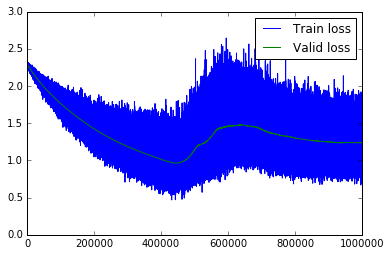

In [5]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

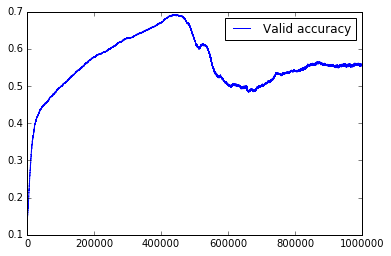

In [6]:
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.legend()
plt.show()